Coupled RFFs for GPs notebook

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import ortho_group
from scipy.stats.distributions import chi2
from tqdm import tqdm
import pandas as pd
from scipy.stats.distributions import chi2
import os
import math

In [195]:
# Hyperparameters and stuff

dataset = 'wine'
test_frac = 0.1


In [185]:
#os.chdir('../data/small_datasets')         #path to dataset directory

if dataset == 'abalone':
    abalone_data = pd.read_csv('abalone.data', delimiter=",")
    all_data = np.asarray(abalone_data)
    all_data = np.hstack((np.asarray([all_data[:,8]]).T, all_data[:,1:7]))
    all_data = np.asarray(all_data,dtype=float)

    #noise = 0.2
    noise = 0.8
    lengthscale = 8
    coefficient = 1

if dataset == 'wine':
    wine_data = pd.read_csv('wine.data', delimiter=",")
    all_data = np.asarray(wine_data)

    #noise = 0.24
    noise = 1
    lengthscale = 6.5
    coefficient = 1

if dataset == 'air':
    air_data = pd.read_csv('AirQualityUCI.csv', delimiter=";")
    all_data = np.asarray(air_data)[:9357,2:15]
    all_data = all_data[:400]
    for row in range(np.shape(all_data)[0]):
        for column in range(np.shape(all_data)[1]):
            all_data[row, column] = float(str(all_data[row,column]).replace(',', '.'))
    new_all_data = []
    for data in all_data:
        if data[0] != -200.0:
            new_all_data.append(data)
    all_data = np.asarray(new_all_data, dtype = float)

if dataset == 'housing':
    housing_data = pd.read_csv('HousingData.csv', delimiter=",")
    all_data = np.asarray(housing_data)
    all_data = np.hstack((np.asarray([all_data[:,13]]).T, all_data[:,:13]))
    new_all_data = []
    for data in all_data:
        if math.isnan(np.mean(data)) == False:
            new_all_data.append(data)
    all_data = np.asarray(new_all_data)

    #noise = 0.11
    noise = 1
    lengthscale = 5
    coefficient = 1.3

if dataset == 'parkinsons':
    parkinsons_data = pd.read_csv('parkinsons_updrs.data', delimiter=",")
    all_data = np.asarray(parkinsons_data)[:,5:]        #doing the 'total' task

    #noise = 0.35
    noise = 1
    lengthscale = 10
    coefficient = 0.5

if dataset == 'cpu':
    machine_data = pd.read_csv('machine.data', delimiter=",")
    all_data = np.asarray(machine_data)[:,2:]
    all_data = np.hstack((np.asarray([all_data[:,7]]).T, all_data[:,:7]))
    all_data = np.asarray(all_data, dtype = float)

    noise = 1
    lengthscale = 4
    coefficient = 10

(159, 13)
[-4.32917154e-17  2.86283925e-17 -4.53864758e-18 -9.63589795e-17
 -2.09476042e-17  4.32917154e-17  2.42643082e-17  8.37904170e-18
 -3.77056876e-17  4.74812363e-17  4.62592927e-18 -1.37905061e-17
 -3.42144203e-17]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(159,)
2.2902713967110147e-16 1.0000000000000002


(array([52.,  0.,  0.,  0.,  0., 66.,  0.,  0.,  0., 41.]),
 array([-1.22209755, -0.95951173, -0.6969259 , -0.43434008, -0.17175425,
         0.09083158,  0.3534174 ,  0.61600323,  0.87858905,  1.14117488,
         1.4037607 ]),
 <BarContainer object of 10 artists>)

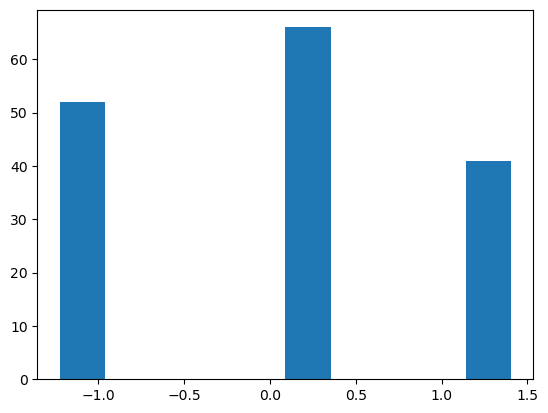

In [223]:
#Load and preprocess data

indices = [i for i in range(len(all_data))]
np.random.shuffle(indices)
all_data = all_data[[indices]][0]

all_data = all_data[:500]

train = all_data[:int(len(all_data) * (1 - test_frac))]
test = all_data[ int(len(all_data) * (1 - test_frac)):]



y_data = train[:,0]
x_data = train[:,1:]

x_data_mean = np.mean(x_data,axis = 0)
x_data_std = np.std(x_data, axis = 0)
x_data -= x_data_mean
x_data *= (1 / x_data_std)
y_mean = np.mean(y_data)
y_std = np.std(y_data)
y_data = (y_data - y_mean) / y_std
#y_data /= y_mean
x_pred = test[:,1:]
x_pred -= x_data_mean
x_pred *= (1 / x_data_std)
y_pred = test[:,0]
y_pred = (y_pred - y_mean) / y_std
#y_pred /= y_mean

d = np.shape(x_data)[1]

print(x_data.shape)
print(np.mean(x_data, axis=0))
print(np.std(x_data, axis=0))
print(y_data.shape)
print(np.mean(y_data), np.std(y_data))
plt.hist(y_data)

In [213]:
# choose the respective orientations of the weights vectors
m=2     #control no. samples

basis = np.eye(d)[:m]                   #orthogonal basis
#basis = np.vstack((basis,-basis))          #antiparallel directions (can include optionally)
nb_vecs = len(basis)


In [214]:
class random_features:
    
    def get_iid_rffs(xs, nb_features, lengthscale): 
    # get iid rffs
        
        for feature in range(nb_features):
            w = np.random.normal(size = (len(basis),d))
            holder = np.matmul(w,np.transpose(xs / lengthscale))
            cs_holder = np.concatenate([np.cos(holder),np.sin(holder)],axis=0)
            if feature == 0:
                rfs = cs_holder
            else:
                rfs = np.vstack((cs_holder,rfs))
        rfs = rfs.T / np.sqrt(nb_features * nb_vecs)
        return rfs

    def get_orth_rffs(xs, ws, lengthscale): 
    #get orthogonal rffs (takes frequency vector norms as input)
        
        nb_features = len(ws)
        for feature, w in enumerate(ws):
            w = np.matmul(np.diag(w),basis)
            rotation = ortho_group.rvs(d)      #get the rotation matrix to apply to all the data
            holder = np.matmul(w,np.matmul(rotation,np.transpose(xs / lengthscale)))
            cs_holder = np.concatenate([np.cos(holder),np.sin(holder)],axis=0)
            if feature == 0:
                rfs = cs_holder
            else:
                rfs = np.concatenate((np.reshape(rfs, [feature,2*nb_vecs,len(xs)]),np.reshape(cs_holder, [1,2*nb_vecs,len(xs)])),axis=0)
        rfs = np.transpose(np.reshape(rfs, [nb_features*2*nb_vecs,len(xs)])) / np.sqrt(nb_features * nb_vecs)
        return rfs
    
    def get_approx_covariance(xs, coupling, nb_features, coefficient, lengthscale, noise = None):
    #construct approx Gram matrix

        if coupling == 'iid':        
            phi = random_features.get_iid_rffs(xs, nb_features, lengthscale)
        elif coupling == 'orth':
            ws = np.sqrt(np.random.chisquare(d,size=(nb_features,len(basis))))
            phi = random_features.get_orth_rffs(xs, ws, lengthscale)
        elif coupling == 'coupled':
            w1 = np.random.random(size=(nb_features,int(len(basis)/2)))
            ws = np.hstack((w1,1-w1))
            if len(basis)%2 == 1:
                ws = np.asarray([np.hstack((ws,np.asarray([np.random.random(nb_features)]).T))])[0]
                
            ws = np.sqrt(chi2.ppf(ws, df=d))
            phi = random_features.get_orth_rffs(xs, ws, lengthscale)
        else:
            raise Exception('Coupling not recognised')

        K_approx = (phi @ phi.T) * coefficient
        if noise is not None:
            K_approx += noise**2 * np.eye(np.shape(x_data)[0])

        return K_approx
    


In [215]:
#functions for GPs stuff

def covariance(x,x_prime,lengthscale,coefficient,noise):
   #get exact covariance matrix for Gaussian kernel

   diff_mat = x[:,None,:]-x_prime[None,:,:]
   cov = coefficient * np.exp(-np.sum(diff_mat**2/(2 * lengthscale**2),axis=2))
   if noise is not None:
       cov = cov + noise ** 2 * np.eye(cov.shape[0])
   return cov

def get_gp_posterior_mean(Kdd,Kpd,y_data):
   #compute posterior mean for datapoints given kernel matrices and observed data
   return Kpd @ np.linalg.solve(Kdd, y_data)

def get_log_likelihood(K, y):
    #Takes Gram matrix and input data, returns data log marginal likelihood for corresponding DP
    n = len(y)
    L = np.linalg.cholesky(K)
    L_diag = [L[i,i] for i in range(len(L))]
    alpha = np.linalg.solve(L.T, np.linalg.solve(L,y))
    log_likelihood = -0.5 * np.dot(y,alpha) - np.sum(np.log(L_diag)) - n/2 * np.log(2 * np.pi)
    return log_likelihood


def do_regression_test(x_data, x_pred, coupling, nb_features, lengthscale, coefficient, noise, y_data, y_pred):
   #try regression and see what error is
   both_x = np.concatenate((x_data,x_pred))
   big_K = random_features.get_approx_covariance(both_x, coupling, nb_features, coefficient, lengthscale, None)
   Kdd = big_K[:len(x_data),:len(x_data)]
   if noise is not None:
      Kdd += np.eye(np.shape(x_data)[0]) * noise**2
   Kpd = big_K[len(x_data):, :len(x_data)]
   return np.mean((Kpd @ np.linalg.solve(Kdd, y_data) - y_pred)**2) / np.mean(y_pred**2)


def get_gp_posterior_mean_and_cov(Kdd, Kpd, Kpp, y_data):
   posterior_mean = Kpd @ np.linalg.solve(Kdd, y_data)
   posterior_cov = Kpp - Kpd @ np.linalg.solve(Kdd, Kpd.T)
   return posterior_mean, posterior_cov

def get_approx_Ks(x_data, x_pred, coupling, nb_features, lengthscale, coefficient, noise, y_data):
   both_x = np.concatenate((x_data,x_pred))
   big_K = random_features.get_approx_covariance(both_x, coupling, nb_features, coefficient, lengthscale, None)
   Kdd = big_K[:len(x_data),:len(x_data)]
   if noise is not None:
      Kdd += np.eye(np.shape(x_data)[0]) * noise**2
   Kpd = big_K[len(x_data):, :len(x_data)]
   Kpp = big_K[len(x_data):,len(x_data):]
   return Kdd, Kpd, Kpp

def get_KL_div(exact_mean, approx_mean, exact_cov, approx_cov):
   KL_d = np.trace(np.linalg.solve(approx_cov, exact_cov)) + (approx_mean - exact_mean).T @ np.linalg.solve(approx_cov, (approx_mean - exact_mean)) - len(exact_mean) + np.log( np.abs(np.linalg.det(approx_cov))) - np.log(np.abs(np.linalg.det(exact_cov))) 
   return KL_d
   

In [216]:
#Compute the exact Gram matrices and posterior mean

Kdd_exact = covariance(x_data, x_data, lengthscale, coefficient, noise)
Kpd_exact = covariance(x_pred, x_data, lengthscale, coefficient, None)
Kpp_exact  = covariance(x_pred, x_pred, lengthscale, coefficient, None)

exact_mean, exact_cov = get_gp_posterior_mean_and_cov(Kdd_exact, Kpd_exact, Kpp_exact, y_data)

In [217]:
couplings = ['iid','orth','coupled']
nb_features = 20

In [218]:
#for comparing log likelihoods. Not sure this is a very good metric.

if False:
    for coupling in couplings:
        nb_tests = 1000
        log = []
        for test in tqdm(range(nb_tests)):
            Kdd_approx = random_features.get_approx_covariance(x_data, coupling, nb_features, coefficient, lengthscale, noise)
            log.append(get_log_likelihood(Kdd_approx, y_data))
        print(str(np.mean(log)) + ' =- ' + str(np.std(log) / np.sqrt(nb_tests)))

In [220]:
#for comparing KL divergence between true and approx dist
if True:
    for coupling in couplings:
        nb_tests = 1000
        log1 = []
        log2 = []
        for test in tqdm(range(nb_tests)):
            Kdd_approx, Kpd_approx, Kpp_approx = get_approx_Ks(x_data, x_pred, coupling, nb_features, lengthscale, coefficient, noise, y_data)
            approx_mean, approx_cov = get_gp_posterior_mean_and_cov(Kdd_approx, Kpd_approx, Kpp_approx, y_data)
            #print(exact_mean.shape, approx_mean.shape, exact_cov.shape, approx_cov.shape)
            #raise Exception
            log1.append(get_KL_div(exact_mean,approx_mean,exact_cov,approx_cov))
            log2.append(np.mean((approx_mean - exact_mean)**2))#  / np.sum(exact_mean**2))
        print(str(np.mean(log1)) + ' =- ' + str(np.std(log1) / np.sqrt(nb_tests)))
        print(str(np.mean(log2)) + ' =- ' + str(np.std(log2) / np.sqrt(nb_tests)))

    

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 3/1000 [00:00<00:49, 20.13it/s]

[ 1.48393666  1.51142025  1.69962965  0.66708843  1.47436223  1.17889965
 -0.27213546 -0.31356415  1.08050466 -1.16364904  1.09311773  1.38461842
 -1.31671348 -0.76880018  0.90830274 -1.1672979   0.12435451 -0.22170815]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.2224172   1.66984605  1.82382339  0.89645065  1.59299122  1.16919773
 -0.37090978 -0.66619218  0.99312382 -1.25572616  1.14001375  1.57809093
 -1.20605927 -0.7915244   0.76763996 -1.2765292   0.12321847 -0.16792968]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.45719353  1.59583332  1.95702807  0.93142526  1.46809538  1.29616013
 -0.27448127 -0.53470741  1.1381642  -1.1679052

  1%|          | 6/1000 [00:00<01:08, 14.47it/s]

[ 1.38778663  1.64730124  1.67075762  0.65124805  1.50943597  1.21205121
 -0.26306485 -0.38564339  1.07106752 -1.25881616  1.1935373   1.55944125
 -1.34406033 -0.7091376   0.88846378 -1.19080596  0.00464442 -0.1441043 ]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.4034988   1.5279581   1.73155943  0.76063902  1.3957377   1.31524257
 -0.31105124 -1.07420747  1.18844673 -1.32268262  1.20626874  1.53717849
 -1.20011067 -0.70225339  0.97025031 -1.11141953  0.08561413  0.15694438]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.450695    1.54576066  1.77897109  0.65292336  1.54824443  1.38522858
 -0.351283   -0.48841067  1.0520607  -1.1860581

  2%|▏         | 22/1000 [00:00<00:20, 48.08it/s]

[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.42232049  1.53588192  1.7944698   0.67178131  1.63265241  1.29855198
 -0.20482861 -0.56538386  0.91704042 -1.21472144  1.14965303  1.38633633
 -1.28330707 -0.73060138  0.87654879 -1.09991929 -0.04071632  0.11380801]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.26486599  1.57782205  1.72095748  0.77452902  1.48004773  1.28418875
 -0.27323066 -0.53747307  1.11653248 -1.20440209  1.14219916  1.41100998
 -1.30763723 -0.76801237  1.04494975 -1.17171572  0.12082293 -0.06830866]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.2515117

  5%|▍         | 47/1000 [00:01<00:14, 64.23it/s]

[ 1.34464581  1.35955402  1.65790975  0.72452961  1.44483882  1.32168224
 -0.28386586 -0.44965061  1.03023738 -1.11049868  1.07499882  1.38808539
 -1.26572073 -0.67438794  1.00355551 -1.02640165 -0.05416238 -0.21563227]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.59913889  1.49470816  1.73609015  0.64040259  1.48775253  1.27684532
 -0.27420807 -0.7215758   1.05916168 -1.23831587  1.13112886  1.39979415
 -1.21734974 -0.66780896  0.93049721 -1.13599651  0.00486224  0.04456838]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.23907152  1.59013482  1.7256835   0.77307496  1.44840746  1.140936
 -0.28376331 -0.7449615   1.0663146  -1.26688219 

  6%|▌         | 62/1000 [00:01<00:11, 83.24it/s]

[ 1.3860743   1.53930518  1.70159813  0.72124122  1.44607552  1.19941641
 -0.32704602 -0.88464002  1.24968157 -1.20429361  1.12666602  1.44457013
 -1.31472855 -0.75909858  1.02047529 -1.11537044  0.10163066 -0.26162254]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.46089936  1.58276265  1.66362221  0.44696366  1.39421178  1.23076776
 -0.24324766 -0.68294171  1.05408577 -1.23826711  1.15842714  1.38723223
 -1.33392161 -0.77220659  1.00137056 -1.11356046  0.11179982 -0.09946414]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.57951947  1.57390669  1.9723635   0.81839327  1.61415819  1.2909047
 -0.4879261  -0.62632598  1.11773907 -1.22204215

  7%|▋         | 73/1000 [00:01<00:13, 70.16it/s]

[ 1.3825912   1.54427545  1.80992636  0.89536726  1.59118129  1.31844486
 -0.23512022 -0.618932    1.01759244 -1.2304761   1.20978392  1.44378145
 -1.33670893 -0.7692036   0.87248046 -1.10080039  0.05054763 -0.05764226]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.3592917   1.4040863   1.68202893  1.01953054  1.40733516  1.34722987
 -0.19999874 -0.64973794  0.90969022 -1.2251027   1.16559508  1.37929646
 -1.19625369 -0.6819443   0.8780656  -1.13773637 -0.03781051  0.13650938]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.42278819  1.53712166  1.66273167  0.7717227   1.41939242  1.32073011
 -0.43323415 -0.32999656  1.18404594 -1.2966276

  8%|▊         | 83/1000 [00:01<00:18, 49.41it/s]

[ 1.4234323   1.47753222  1.50430888  0.60643511  1.34742632  1.45920361
 -0.23350864 -0.69900753  1.16575395 -1.18228267  1.1108869   1.56290214
 -1.31059345 -0.71631938  0.9245484  -1.09951925  0.11562715 -0.03216018]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.47201191  1.44289942  1.70025746  0.66167571  1.47712962  1.32218744
 -0.22659441 -0.45169457  0.94668836 -1.23714374  1.13357218  1.38580254
 -1.20064311 -0.75350354  0.92486569 -1.04688521  0.06582699 -0.02444097]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.50149147  1.51781924  1.74493193  0.73740878  1.54582854  1.12500549
 -0.22305872 -0.4564239   0.91090293 -1.2580505

  9%|▉         | 91/1000 [00:02<00:34, 26.02it/s]

[ 1.39627642  1.56187268  1.69877926  0.86030201  1.550513    1.22611548
 -0.24543251 -0.96551864  0.96910837 -1.21459557  1.12682976  1.40436983
 -1.26860214 -0.69866225  0.99803789 -1.09509573  0.02839056  0.08221467]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.51016868  1.57172943  1.77995935  0.76867644  1.43567874  1.05831955
 -0.40696866 -0.5889374   1.05406867 -1.25127678  1.1082654   1.39126968
 -1.28241245 -0.78001758  0.83704985 -1.04658989 -0.14005309 -0.02692172]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.37680569  1.54935952  1.74974554  0.82680798  1.49489289  1.14515493
 -0.3046993  -0.50046367  0.8703839  -1.2972219

 11%|█▏        | 113/1000 [00:02<00:23, 37.21it/s]

[ 1.35750877  1.6263142   1.9337418   0.77656882  1.54539119  1.20868792
 -0.23825936 -0.60201859  1.2810518  -1.31085881  1.04014012  1.49338828
 -1.35407478 -0.61995993  1.17006345 -1.13257947  0.05066824 -0.03747411]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.39867258  1.48909008  1.71262355  0.78412146  1.5199484   1.32938651
 -0.23091564 -0.71476647  0.91052607 -1.15481993  1.14868996  1.40513646
 -1.3342045  -0.7542187   0.84215754 -1.14433357 -0.10144035  0.08921831]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.35581825  1.63630549  1.77696543  0.72038073  1.56923476  1.13758419
 -0.19952771 -0.68916274  0.99673366 -1.2534428

 14%|█▍        | 142/1000 [00:03<00:13, 65.43it/s]

[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.3163347   1.5555001   1.77263977  0.79456834  1.5570416   1.5221078
 -0.25764861 -0.35309126  1.14957358 -1.21878497  1.20785463  1.50085867
 -1.36700771 -0.713345    1.0565891  -1.20110112  0.10327819  0.02913552]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.59789628  1.56662377  1.79278612  0.51877502  1.59382717  1.25710173
 -0.20351893 -0.54772481  0.91880313 -1.21979709  1.09569785  1.50231198
 -1.2072245  -0.78129782  0.81047501 -1.16407583  0.16106818  0.02241238]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178

 17%|█▋        | 169/1000 [00:03<00:09, 86.33it/s]

[ 1.24380187  1.48242124  1.75794963  0.83084851  1.45986427  1.30792318
 -0.18879497 -0.56926401  1.06709007 -1.20607347  1.24119913  1.34588914
 -1.25592914 -0.84272618  0.98521349 -1.07054116 -0.03373736 -0.17350047]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.3723672   1.52062878  1.73099897  0.66695462  1.50422448  1.32029108
 -0.2119246  -0.64294885  1.03798518 -1.23223606  1.20543844  1.46253481
 -1.3883621  -0.67930272  0.92906957 -1.21881081  0.16742495 -0.06634439]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.58083883  1.53023035  1.79069785  0.59101933  1.47915231  1.26434458
 -0.42516012 -0.21293363  1.08005349 -1.2371319

 18%|█▊        | 181/1000 [00:03<00:10, 78.54it/s]

[ 1.1810537   1.66122088  1.78948223  0.81256018  1.59434478  1.27243378
 -0.23926272 -0.60677238  0.83548716 -1.2878634   1.21239596  1.55548395
 -1.32708357 -0.67667512  0.71079228 -1.05813454  0.21902799 -0.2707681 ]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.47506845  1.55025562  1.70202929  0.76458072  1.54171853  1.2981914
 -0.29414437 -0.38277227  1.0171964  -1.20612032  1.0491271   1.43378334
 -1.3303593  -0.75110516  0.97168014 -1.17537449 -0.00387588 -0.20924448]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.58190475  1.63503125  1.7871035   0.69868902  1.52600465  1.20259167
 -0.25597043 -0.54021023  1.0432     -1.2517314 

 19%|█▉        | 192/1000 [00:03<00:11, 69.77it/s]

[ 1.37785942  1.46378801  1.6464524   0.64536658  1.4991758   1.21381081
 -0.3125785  -0.69805356  1.05891194 -1.21120936  1.06092756  1.36427065
 -1.29719907 -0.62134289  0.96901285 -0.98973738 -0.02713917 -0.00334795]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.56065078  1.42740114  1.46885225  0.52043705  1.41268186  1.36122993
 -0.20133884 -0.74428751  0.95277328 -1.10036839  1.08816902  1.41137434
 -1.37926376 -0.63315326  0.87964614 -1.13722944  0.10872308  0.07717039]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.38732969  1.62155252  1.5629641   0.65141093  1.44206477  1.33362691
 -0.35764855 -0.73460388  1.12363071 -1.2334412

 21%|██        | 209/1000 [00:03<00:08, 87.93it/s]

[ 1.28997109  1.40365649  1.63560557  0.79193981  1.45028658  1.3343309
 -0.29136621 -0.91723919  1.14654947 -1.18699882  1.1784591   1.38221578
 -1.27898965 -0.65288409  1.00825281 -1.07801001 -0.15173549  0.0473829 ]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.50854694  1.59855643  1.79271894  0.66557604  1.55698283  1.21540753
 -0.32187953 -0.59691432  0.96649976 -1.19438315  0.99938122  1.5330154
 -1.2964218  -0.73857237  0.86415772 -1.12360465 -0.03577047 -0.02134912]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.47339659  1.52069241  1.66260855  0.66675642  1.50144239  1.18710407
 -0.25562969 -0.8397129   0.99157086 -1.17537815 

 22%|██▏       | 220/1000 [00:04<00:13, 55.84it/s]

[ 1.26954628  1.49657803  1.63378392  0.82225458  1.46456199  1.23121378
 -0.20585567 -0.58207511  0.98860276 -1.21752261  1.10238954  1.46684956
 -1.29305372 -0.75102529  0.78602387 -1.27798139  0.00282998 -0.01983466]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.32287085  1.54428156  1.76728208  0.88433962  1.48651617  1.26610163
 -0.28195577 -0.69676351  1.09911354 -1.210842    1.1244499   1.46319366
 -1.19915601 -0.78009669  0.98043791 -1.1613842   0.02135302 -0.04189431]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.36719969  1.63254245  1.83682927  0.84747188  1.57570027  1.26916591
 -0.25304351 -0.31807004  1.17431071 -1.3369007

 23%|██▎       | 233/1000 [00:04<00:11, 66.27it/s]

[ 1.50059873  1.45619543  1.77871823  0.78229336  1.57792184  1.26793795
 -0.12048047 -0.77239178  0.99768676 -1.25766034  1.16390345  1.22296366
 -1.28555105 -0.70461065  0.98963019 -1.04834864 -0.02502704  0.14284993]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.54513973  1.47660563  1.85784945  0.72626631  1.63664786  1.50909212
 -0.28857836 -0.85620582  1.11701591 -1.16921437  1.17862865  1.46914325
 -1.30994759 -0.75081217  0.96863329 -1.16821485  0.13228799  0.12809618]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.60291848  1.66891345  1.76385413  0.53514899  1.72132523  1.23752988
 -0.39421181 -0.71040028  1.12844254 -1.1487076

 26%|██▌       | 258/1000 [00:04<00:12, 57.89it/s]

[ 1.60222197  1.55583758  1.82537081  0.6820222   1.47293579  1.16238562
 -0.33473872 -0.46322758  1.11612408 -1.19291711  1.09060286  1.4459506
 -1.27807878 -0.65910401  0.98966109 -1.11982404  0.05588244 -0.07296512]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.49217475  1.69460606  1.91121531  0.676951    1.71854562  1.25005812
 -0.26957515 -0.43708451  0.95076552 -1.21532831  1.10221328  1.48293843
 -1.36486948 -0.71683124  0.87709143 -1.20773734  0.08047523 -0.15470379]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.21241325  1.45158634  1.61305136  0.70030552  1.45253653  1.29282325
 -0.19993094 -0.53700056  1.07886301 -1.24375056

 28%|██▊       | 278/1000 [00:05<00:10, 67.67it/s]

[ 1.45622444e+00  1.54737548e+00  1.74449726e+00  5.14737733e-01
  1.56116709e+00  1.16164820e+00 -3.05636272e-01 -5.29388600e-01
  9.87618208e-01 -1.21178109e+00  1.05607052e+00  1.35509680e+00
 -1.27185857e+00 -6.99487458e-01  9.41487759e-01 -1.11065033e+00
 -1.24766008e-03 -1.77648533e-03]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.54113084  1.49702186  1.82171623  0.86752026  1.56490391  1.32256798
 -0.38146676 -0.46872781  1.2104252  -1.21454174  1.17329422  1.36818927
 -1.27155954 -0.67723841  1.0624025  -1.07805929  0.08090666  0.08245569]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.44967318  1.47479225  1.56421142  0.541294

 30%|███       | 303/1000 [00:05<00:07, 87.76it/s]

[ 1.26438133  1.58480952  1.72700758  0.73134294  1.54966475  1.23827975
 -0.25093697 -0.52019469  1.02656096 -1.1983029   1.14636955  1.53432514
 -1.26916848 -0.67967459  0.89977124 -1.16589871  0.12233661 -0.10129064]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.20814905  1.46636948  1.65930946  0.79520733  1.48108172  1.33383731
 -0.2335163  -0.65107255  0.83742328 -1.24371656  1.22768318  1.3418424
 -1.22160322 -0.77843719  0.71687635 -1.19237124  0.10352053 -0.10632511]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.37819869  1.58344101  1.8258239   0.7304063   1.54842802  1.32536783
 -0.38589265 -0.31219358  1.09471619 -1.3097415 

 31%|███▏      | 314/1000 [00:06<00:16, 42.00it/s]

[ 1.40936241  1.62967265  1.80754214  0.76615162  1.49797417  1.30461565
 -0.35134419 -0.57141857  1.29125589 -1.31714997  1.25354752  1.57218675
 -1.28143918 -0.77059177  0.97203708 -1.22628687  0.08692881 -0.15985451]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.3658035   1.59071207  1.77386809  0.69678639  1.49981955  1.18088476
 -0.30973781 -0.3615274   1.11422422 -1.28899246  1.25428832  1.44552147
 -1.23084275 -0.69664701  0.97628053 -1.16720475  0.04802458 -0.11777217]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.72304409  1.55263945  1.80932177  0.58188149  1.5118334   1.42281798
 -0.28505875 -0.75140585  1.02831594 -1.1652702

 32%|███▏      | 322/1000 [00:06<00:22, 30.47it/s]

[ 1.32386233  1.5702703   1.82991894  0.77908695  1.51936239  1.38181731
 -0.3012902  -0.50239997  1.16633838 -1.3010055   1.21059757  1.51362107
 -1.26385316 -0.68723845  1.05125348 -1.14785898  0.06530608  0.23016589]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.25647629e+00  1.53677296e+00  1.70165514e+00  6.44946910e-01
  1.56691193e+00  9.84218959e-01 -2.63625448e-01 -9.22275308e-01
  8.68894065e-01 -1.22348921e+00  1.05171622e+00  1.33576230e+00
 -1.26506079e+00 -7.56760809e-01  8.34473875e-01 -1.07665747e+00
 -3.30749510e-04 -2.20900957e-01]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.30165572  1.51522039  1.71874526  0.757387

 33%|███▎      | 328/1000 [00:06<00:24, 27.01it/s]

[ 1.27913403  1.5588754   1.80993391  0.90007452  1.51315955  1.25077852
 -0.24428858 -0.59775822  1.0767572  -1.24404706  1.25401361  1.38835146
 -1.43386503 -0.73324161  1.03968241 -1.15863953  0.04286206 -0.20492928]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.62304728  1.58999698  1.75154972  0.76048537  1.53720128  1.24132508
 -0.18760276 -0.5125184   1.18285574 -1.29669888  1.08979956  1.55769919
 -1.25605622 -0.83025946  1.07404091 -1.12954797  0.13443614 -0.00732122]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.56009119  1.47632785  1.78887813  0.78601665  1.58776433  1.51251818
 -0.25773129 -0.76154286  1.04561724 -1.1866526

 35%|███▍      | 348/1000 [00:07<00:15, 40.95it/s]

[ 1.42648557  1.66670545  1.79292348  0.66186101  1.54701654  1.11758009
 -0.41199304 -0.3812023   0.93331365 -1.27547224  1.10183872  1.54953683
 -1.34125045 -0.7744525   0.75400083 -1.25317414  0.1535348  -0.08636675]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.42583338  1.54352351  1.68675583  0.79813935  1.4244348   1.2384048
 -0.27510371 -0.33881871  1.08671045 -1.26826025  1.10402767  1.54116404
 -1.21624942 -0.68725348  0.9453877  -1.17039796  0.08307698 -0.22724779]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.3750233   1.45062346  1.71941167  0.75420922  1.5025039   1.28915641
 -0.23880568 -0.60124224  0.96267441 -1.22593932

 36%|███▌      | 358/1000 [00:07<00:12, 51.22it/s]

[ 1.36387603  1.50007768  1.77839788  0.75971872  1.53273892  1.34925166
 -0.26989718 -0.84583526  1.00086874 -1.17721486  1.09098226  1.33669571
 -1.21507924 -0.70663889  0.94004581 -1.06773912  0.05075137  0.03317399]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.41050612e+00  1.55666718e+00  1.76091429e+00  6.68084123e-01
  1.53275188e+00  1.18427236e+00 -2.80419316e-01 -6.27236872e-01
  9.85412003e-01 -1.28627904e+00  1.18683595e+00  1.43226338e+00
 -1.28935373e+00 -7.39693130e-01  8.94228086e-01 -1.22711127e+00
  2.53828927e-02 -1.58839566e-03]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.54264262  1.5076079   1.77931084  0.721626

 38%|███▊      | 382/1000 [00:07<00:09, 65.61it/s]

[ 1.57362398  1.52765317  1.7302959   0.4616458   1.43054957  1.34519536
 -0.36864587 -0.5392429   1.18292697 -1.29247094  1.11931229  1.54900663
 -1.39591425 -0.64805593  1.11474803 -1.18265699  0.24505947  0.05025293]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.20841070e+00  1.59906048e+00  1.91032029e+00  8.13855352e-01
  1.60243874e+00  1.27768666e+00 -3.14941676e-01 -4.57022653e-01
  1.01482706e+00 -1.16687399e+00  1.18151246e+00  1.51036232e+00
 -1.31087672e+00 -7.52188223e-01  9.42993134e-01 -1.12793246e+00
 -1.76610959e-03 -4.47684087e-02]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.34874661  1.50507831  1.56350318  0.793993

 40%|███▉      | 399/1000 [00:07<00:06, 86.20it/s]

[ 1.20360581  1.41102038  1.56226857  0.82434044  1.32062017  1.2995439
 -0.23361777 -0.81716403  1.13906493 -1.20879166  1.11354409  1.41296518
 -1.37548333 -0.77124102  1.05585564 -1.15625317  0.06963207 -0.07359337]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.17525508  1.5681996   1.77022069  0.73819648  1.49100508  1.12443595
 -0.31862541 -0.46263135  1.10489148 -1.20351377  1.08631843  1.35975415
 -1.35007313 -0.75179156  1.092738   -1.05365556  0.1934838  -0.13273665]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.41036632  1.50582773  1.74845911  0.7433404   1.52310483  1.23491439
 -0.31802234 -0.69943146  1.02029058 -1.22548612

 41%|████      | 411/1000 [00:08<00:08, 68.28it/s]

[ 1.29852139  1.64216364  1.84458329  0.67386049  1.61246943  1.33971663
 -0.29948594 -0.54375032  1.20606753 -1.3278227   1.23430386  1.50729521
 -1.36292074 -0.80466135  1.01390617 -1.12035214  0.0045638   0.07452147]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.29446816  1.3327522   1.57095192  0.77190208  1.38388978  1.43257274
 -0.14888062 -0.66021757  1.00745998 -1.22419194  1.19608788  1.23817203
 -1.31286573 -0.82679049  0.91438634 -1.06384854 -0.06980164  0.19364176]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.28304431  1.52337415  1.7176332   0.79612433  1.48300152  1.29172149
 -0.19356573 -0.84226391  1.08240884 -1.2797669

 42%|████▏     | 421/1000 [00:08<00:14, 41.22it/s]

[ 1.41415388  1.56472221  1.71777664  0.80483529  1.49776762  1.1191297
 -0.29950523 -0.4953275   1.18089644 -1.259419    1.16022068  1.38935881
 -1.30705987 -0.78186018  1.05397573 -1.18997746 -0.04483926 -0.03241872]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.32054714  1.56168508  1.81797527  0.77822561  1.56263499  1.26100556
 -0.26936242 -0.63852462  0.92265035 -1.22583226  1.08294259  1.32098363
 -1.21104381 -0.62401559  0.91054963 -1.10074693 -0.05283887 -0.08388479]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.42559218  1.50007647  1.75408336  0.68378838  1.56664376  1.27959447
 -0.27709798 -0.55511833  1.01463752 -1.16110627

 43%|████▎     | 428/1000 [00:08<00:13, 43.27it/s]

[ 1.38668321  1.46896662  1.71613465  0.73492179  1.53047837  1.22702017
 -0.19950974 -0.662432    0.86094525 -1.24435703  1.09035824  1.38939486
 -1.26752623 -0.79704713  0.8977679  -1.17891938  0.03535574  0.04526771]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.02273501  1.58797403  1.66199943  0.6876807   1.41773125  1.26300199
 -0.2939297  -0.60925049  1.33769076 -1.3525716   1.26173243  1.58287323
 -1.30127137 -0.72403762  0.99244132 -1.20311729 -0.03010704 -0.1669084 ]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]


 45%|████▌     | 450/1000 [00:09<00:11, 47.90it/s]

[ 1.15695985  1.70057205  1.80007603  0.84031909  1.47131834  0.93831701
 -0.24340961 -0.65248124  1.13058654 -1.24454647  1.20318369  1.57016233
 -1.29330564 -0.8727205   0.95731403 -1.23683491  0.08792899 -0.14256329]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.39652131  1.55482656  1.81176928  0.72010361  1.49186587  1.31593552
 -0.21193123 -0.81449465  1.12739919 -1.22633014  1.18871907  1.46272495
 -1.34185219 -0.71114439  0.91691389 -1.0349169  -0.09535835 -0.00506899]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.24907464  1.5108772   1.67486424  0.83489437  1.52319212  1.19996337
 -0.16876286 -0.64030726  0.96461657 -1.3119058

 49%|████▉     | 493/1000 [00:09<00:05, 98.34it/s]

[ 1.5107135   1.56739431  1.87367716  0.76536907  1.52603298  1.46004894
 -0.30521019 -0.32103811  1.112739   -1.31189235  1.27568556  1.40445223
 -1.29775843 -0.67837813  1.06759466 -1.17944731  0.25141527  0.13851767]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.48107464  1.3971906   1.54370953  0.89083413  1.3312081   1.31809506
 -0.3479628  -0.60751966  1.13775836 -1.28658852  1.16896805  1.36979876
 -1.32386443 -0.77426921  0.97474814 -1.15105904  0.01525386 -0.02762369]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.25893249  1.4565678   1.63567023  0.72958424  1.50913177  1.19704712
 -0.220841   -0.59872908  0.91592945 -1.2519710

 51%|█████     | 508/1000 [00:10<00:09, 50.80it/s]

[ 1.54153387  1.4715629   1.53593693  0.75589261  1.33639915  1.31664566
 -0.39659553 -0.44232699  1.09666558 -1.09289054  1.059948    1.39995652
 -1.24037495 -0.64449374  0.94017594 -1.05356122 -0.10602005 -0.21520621]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.24654065e+00  1.44669491e+00  1.58561306e+00  7.68220159e-01
  1.33719188e+00  1.07463677e+00 -2.02997202e-01 -8.62644581e-01
  1.08800158e+00 -1.24188596e+00  1.15919736e+00  1.46403032e+00
 -1.33493162e+00 -7.55090903e-01  9.44405623e-01 -1.13073892e+00
  3.08276859e-04 -6.40789492e-02]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.50480234  1.46000891  1.50448564  0.715115

 53%|█████▎    | 528/1000 [00:10<00:10, 45.86it/s]

[ 1.58656012  1.49189393  1.69809489  0.54562409  1.44016942  1.20385066
 -0.1925923  -0.96067312  1.2661695  -1.23284548  1.1214107   1.34857243
 -1.38662606 -0.86236246  1.15714189 -1.10353042  0.10143978  0.06364247]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.48352924  1.55733094  1.74348008  0.78850986  1.48967574  1.34487804
 -0.38466185 -0.3177042   1.23110104 -1.27253937  1.16853923  1.50311952
 -1.1834201  -0.70147386  1.09367813 -1.14185336  0.14047927 -0.32395401]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.52799577  1.59632758  1.79486442  0.64235702  1.56234346  1.32269294
 -0.30792888 -0.48228001  1.00799775 -1.1752214

 54%|█████▍    | 542/1000 [00:10<00:08, 51.02it/s]

[ 1.44168625  1.493807    1.73172349  0.68122431  1.48605273  1.5227031
 -0.27427717 -0.76689764  0.93784313 -1.10521582  1.17974632  1.39104755
 -1.38049824 -0.68308893  0.8491786  -1.01222969  0.23818783 -0.15402697]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.25664771  1.42417475  1.63561263  0.76201896  1.26542404  1.15191587
 -0.3477938  -0.47127482  1.02746261 -1.18103188  1.16116999  1.37227896
 -1.39091242 -0.67212631  0.9637054  -1.00851718  0.17560169 -0.15909401]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.57394755  1.52031072  1.7136696   0.84906967  1.50252857  1.22201075
 -0.38443748  0.0535448   1.10090558 -1.24201709

 56%|█████▋    | 565/1000 [00:11<00:08, 51.50it/s]

[ 1.3124513   1.55251415  1.81512571  0.72367451  1.47510503  1.20303918
 -0.27575891 -0.33452492  0.94349149 -1.2001355   1.13586167  1.37150267
 -1.19407383 -0.66429451  0.841184   -1.10768703  0.01768963 -0.3539441 ]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.37000229  1.73039729  1.75155451  0.5484628   1.51766248  1.3279953
 -0.51516656 -0.45020567  1.24253007 -1.2522214   1.26695245  1.41633717
 -1.22899298 -0.71626824  1.06408534 -1.05066718  0.08681802 -0.1400746 ]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.42860969  1.50561461  1.65122139  0.64705119  1.41825863  1.25454928
 -0.30906577 -0.5668827   1.14196604 -1.17480152

 60%|██████    | 603/1000 [00:11<00:04, 91.93it/s]

[ 1.52410818  1.58836032  1.77309492  0.67579473  1.43795593  1.20275096
 -0.30482925 -0.51732503  1.09990333 -1.32390787  1.19095233  1.46756926
 -1.33675901 -0.72869483  0.93053971 -1.15833748  0.11728122 -0.23647086]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.44144334  1.52726556  1.67952188  0.80809508  1.51213288  1.3936836
 -0.29822753 -0.85342023  0.94523295 -1.18112511  1.13473701  1.4675811
 -1.26308982 -0.80429595  0.8197717  -1.15138801  0.0397942   0.04048895]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.24977738  1.48391678  1.64185777  0.65589571  1.45967438  1.22010723
 -0.29259067 -0.6570914   1.05462385 -1.24972637 

 63%|██████▎   | 632/1000 [00:11<00:03, 108.88it/s]

[ 1.35814826  1.51579844  1.79354097  0.88606886  1.50548218  1.38358287
 -0.28078058 -0.73130286  1.12610762 -1.22316947  1.06385969  1.54350829
 -1.31633458 -0.73416863  1.04163706 -1.08517463 -0.02038588 -0.17872985]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.48528393  1.46512243  1.68409452  0.74673271  1.42812973  1.35636277
 -0.21485987 -0.30668728  0.95029627 -1.23150746  1.11627644  1.39929889
 -1.31413271 -0.65069703  0.82667841 -1.08667989 -0.06426966 -0.08159337]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.45231171  1.42167368  1.744812    0.71960307  1.49293935  1.28496342
 -0.35792354 -0.25593808  0.9995374  -1.2530768

 65%|██████▍   | 649/1000 [00:11<00:02, 122.39it/s]

[ 1.4125224   1.55122646  1.70582918  0.66450144  1.41425716  1.26295711
 -0.31798752 -0.64645601  1.11721348 -1.24818726  1.11474575  1.4841898
 -1.38101254 -0.69897656  0.95334025 -1.13443217  0.18164187 -0.27107061]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.16016996  1.55486276  1.70286903  0.78685193  1.45149314  1.16084124
 -0.28122976 -0.67386151  0.83900664 -1.26045575  1.0956455   1.42320394
 -1.29946502 -0.72311161  0.78497493 -1.14475278  0.04629964 -0.16244716]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.37739813  1.5312609   1.71598895  0.81123278  1.39335789  1.20315522
 -0.24385283 -0.62785981  1.11313977 -1.22431636

 68%|██████▊   | 678/1000 [00:12<00:02, 109.75it/s]

[ 1.42829578  1.60868488  1.79051773  0.81264112  1.48557702  1.21103238
 -0.37724503 -0.39446227  1.0960129  -1.2871795   1.0425166   1.56726866
 -1.22937894 -0.76308701  0.97934191 -1.2350877  -0.03238387 -0.1332109 ]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.43340284  1.50391469  1.75207664  0.70315668  1.5934435   1.27610894
 -0.24015161 -0.30119918  1.00768503 -1.24564842  1.10357153  1.38976941
 -1.36032042 -0.73656567  0.9543549  -1.20191812  0.15737231 -0.07192687]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.2905869   1.49513424  1.67227272  0.65419854  1.51382636  1.39148891
 -0.34311539 -0.24300272  1.03395664 -1.3010182

 71%|███████   | 708/1000 [00:12<00:02, 123.93it/s]

[ 1.33670203  1.5878421   1.87815938  0.84364746  1.59098342  1.23096001
 -0.36240729 -0.59411205  1.00581073 -1.25720435  1.21030506  1.40981749
 -1.26750182 -0.67058006  0.92137321 -1.14597973 -0.07484295 -0.05116141]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.45146329  1.48654858  1.69744545  0.77154142  1.44699599  1.35134541
 -0.2148792  -0.70002567  1.00580794 -1.26075966  1.1173468   1.47027833
 -1.1794714  -0.64601414  0.85986289 -1.09600492  0.09605592 -0.25572544]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.63905686  1.4637349   1.69958136  0.58705296  1.47857417  1.52750627
 -0.27843619 -0.5011164   1.00502818 -1.0764355

 72%|███████▏  | 722/1000 [00:12<00:03, 87.52it/s] 

[ 1.48565298  1.47886484  1.72385498  0.84976442  1.39992255  1.29000059
 -0.42039617 -0.25053133  1.02887063 -1.26395874  1.14869473  1.44383054
 -1.22236471 -0.67617702  0.91079718 -1.15417453 -0.07531752 -0.18052599]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.57027794  1.37029345  1.59574587  0.7329459   1.33779016  1.40423917
 -0.28249083 -0.78190055  1.09022104 -1.29918193  1.165283    1.32755731
 -1.34600245 -0.66506759  1.05658941 -1.09559294 -0.02848684  0.1129227 ]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.37970735  1.40462744  1.63196458  0.7330803   1.4414086   1.33062037
 -0.23703278 -0.57629874  0.9500765  -1.2905616

 76%|███████▌  | 760/1000 [00:12<00:01, 128.33it/s]

[ 1.33193022  1.5712248   1.79078528  0.75449213  1.50417213  1.30496373
 -0.19576687 -0.38489376  1.02183491 -1.28740154  1.16721668  1.47196691
 -1.29668989 -0.74183705  0.95939171 -1.21770801  0.04831635 -0.03021489]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.38604952  1.51477053  1.80808415  0.76869502  1.48301244  1.28350768
 -0.33879333 -0.73911349  1.08549645 -1.23252869  1.07664014  1.38076336
 -1.20634268 -0.75389598  1.02790559 -1.09099246  0.02855465 -0.1750351 ]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.44401627  1.55106951  1.62305131  0.63680584  1.43790248  1.29195447
 -0.21542373 -0.7036491   1.05435167 -1.1479773

 80%|███████▉  | 798/1000 [00:12<00:01, 156.79it/s]

[ 1.54572586  1.4348891   1.66299352  0.6732282   1.3814983   1.28512993
 -0.28260126 -0.69672615  1.21751134 -1.16256613  1.08818305  1.37658215
 -1.31233353 -0.71563777  1.04120834 -1.04121915 -0.0243275  -0.17195571]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.28320267  1.42162388  1.42401766  0.63856919  1.30714353  1.44824917
 -0.3301535  -0.50434078  1.08540515 -1.25882615  1.19990672  1.44303847
 -1.3611601  -0.72998537  0.9168598  -1.1195694   0.15742438 -0.10447403]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.15062026  1.49516276  1.69339034  0.80083871  1.55393811  1.25492868
 -0.20134596 -0.69605891  0.94187987 -1.2215830

 84%|████████▎ | 835/1000 [00:13<00:01, 159.91it/s]

[ 1.49409244  1.48549807  1.43635895  0.56888047  1.38624093  1.21500933
 -0.26842497 -0.49486975  1.11806677 -1.2936539   1.13193814  1.46837344
 -1.30212731 -0.69361665  0.90538035 -1.17677737 -0.0153859  -0.13795647]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.39548141  1.61117524  1.7750767   0.72143348  1.53117557  1.30724337
 -0.2459965  -0.65125684  1.24148889 -1.29587885  1.22984162  1.42212943
 -1.34580792 -0.74965773  1.07673101 -1.18927804 -0.04034777  0.28589424]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.57985677  1.55928917  1.71325247  0.59754639  1.47606421  1.34077772
 -0.20787126 -0.79181208  1.09882032 -1.1370629

 87%|████████▋ | 871/1000 [00:13<00:00, 166.11it/s]

[ 1.63272841  1.41445917  1.87205323  0.71892133  1.38515522  1.32624476
 -0.38937027 -0.4752714   1.06836094 -1.20202755  1.04994109  1.29696927
 -1.41400403 -0.77083529  1.08760579 -1.12715409  0.083995   -0.04723829]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.51536372  1.55987231  1.73514732  0.68605051  1.51800578  1.3445065
 -0.30559821 -0.48506939  0.95276451 -1.25747414  1.059278    1.5208289
 -1.34625076 -0.76474068  0.88651525 -1.2694562   0.04740941 -0.06875577]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.46416986  1.54636902  1.70753182  0.87127881  1.67161448  1.31991624
 -0.33550787 -0.52782564  0.99433162 -1.26154666 

 91%|█████████ | 910/1000 [00:13<00:00, 176.54it/s]

[ 1.38585138  1.56451955  1.68823304  0.71477806  1.45896867  1.14690426
 -0.41401112 -0.74818999  1.01642614 -1.19899001  1.11463584  1.43568665
 -1.24261851 -0.72390231  0.8959843  -1.15125419  0.06606121 -0.29910529]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.54108484  1.48812776  1.65318153  0.56873119  1.48180137  1.41488196
 -0.24793158 -0.54590498  1.04952552 -1.1610137   1.05280623  1.34416233
 -1.28203435 -0.74550156  0.99236236 -1.13350997  0.11700599  0.00431044]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.45027298  1.47485931  1.72823756  0.67182034  1.44683256  1.46470637
 -0.28632848 -0.38521228  1.06931342 -1.2306116

 95%|█████████▌| 952/1000 [00:13<00:00, 189.20it/s]

[ 1.38493359  1.44680494  1.75244229  0.92438296  1.43634789  1.51153958
 -0.3016736  -0.40171238  1.10436891 -1.27351914  1.19593592  1.4415827
 -1.26252809 -0.65910102  0.97980398 -1.08568953  0.17156053 -0.1557193 ]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.22618003  1.51893124  1.65808244  0.74734949  1.36330755  1.29429196
 -0.18531701 -0.59351032  0.95846628 -1.20687573  1.23576402  1.41357405
 -1.28999401 -0.74951805  0.87610647 -1.14325323  0.10278864 -0.13091021]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.55454253  1.59977007  1.85085242  0.69096231  1.52439434  1.52647173
 -0.37464492 -0.5529526   1.3379919  -1.36674202

 97%|█████████▋| 972/1000 [00:13<00:00, 179.49it/s]

[ 1.40235894  1.41925757  1.73921089  0.67084039  1.50002866  1.37666106
 -0.3376305  -0.69374287  1.02398443 -1.12621779  0.97323135  1.32405225
 -1.20639036 -0.73920362  1.12992887 -0.97549498  0.06773732  0.09586091]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.09380608  1.60940877  1.86541015  0.63652919  1.58207299  1.1925342
 -0.357739   -0.7981317   1.05461241 -1.19279184  1.12682237  1.46218699
 -1.32218764 -0.75182508  0.90825226 -1.20973571  0.22332087 -0.14520018]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.5880193   1.61736716  1.72578968  0.63299673  1.568314    1.33473592
 -0.30391056 -0.68902736  1.13077166 -1.21997144

100%|██████████| 1000/1000 [00:14<00:00, 70.79it/s]


[ 1.45974234  1.41753819  1.56047725  0.72158803  1.26530691  1.26300361
 -0.28353071 -0.65021178  1.12711431 -1.18996041  1.11534899  1.40070165
 -1.35128557 -0.68664669  0.90555361 -1.17869027  0.16649019 -0.17190869]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.32519216  1.39006188  1.56594464  0.92506671  1.46241809  1.43607259
 -0.20469022 -0.72485428  1.06151771 -1.28744662  1.25871652  1.4307003
 -1.29742123 -0.81442281  0.89235132 -1.24100613  0.06249922 -0.0262364 ]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.62221506  1.49349739  1.7032133   0.63460965  1.56229758  1.50286576
 -0.28375099 -0.33996312  1.14888642 -1.23509884

  2%|▏         | 15/1000 [00:00<00:06, 144.40it/s]

[ 1.47378498  1.68580442  1.91573966  0.56377777  1.65293025  1.20820414
 -0.4378916  -0.49878443  1.04557042 -1.25298714  1.13644988  1.46780793
 -1.20192304 -0.80257502  0.93494968 -1.19192055  0.13826648 -0.17429827]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.3568301   1.46527024  1.64294823  0.53189629  1.45199602  1.18645214
 -0.17724657 -0.72398656  0.91981531 -1.24185564  1.14578317  1.42854154
 -1.27284045 -0.66105253  0.83674734 -1.19915907  0.06726863 -0.2282591 ]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.50901146  1.50476091  1.70106352  0.59934611  1.38338719  1.37271937
 -0.26944855 -0.43107895  1.08895315 -1.3142151

  3%|▎         | 31/1000 [00:00<00:06, 153.11it/s]

[ 1.39630311  1.4540946   1.5973864   0.67937591  1.51713446  1.35804161
 -0.25743272 -0.65057952  1.00568779 -1.25101199  1.04607054  1.49667644
 -1.20783254 -0.67092387  0.86011325 -1.20764317  0.13220689 -0.15050742]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.62377523  1.6205816   1.73905081  0.82941639  1.51268783  1.31369644
 -0.40372403 -0.3748884   1.15339637 -1.26497775  1.04645973  1.63269878
 -1.37149129 -0.69946994  0.88126221 -1.16784659  0.05551881 -0.0758386 ]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.49272751  1.35280291  1.52089279  0.58536486  1.38104166  1.27971638
 -0.24510947 -0.58628426  1.02908543 -1.1899868

  5%|▍         | 48/1000 [00:00<00:06, 158.41it/s]

[ 1.33331423  1.55184916  1.79243012  0.73204495  1.41794553  1.14369816
 -0.32969764 -0.65625106  1.08551434 -1.26114922  1.10792025  1.40746321
 -1.19794441 -0.71693947  0.95527061 -1.06002603  0.00875495 -0.16522593]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.43196705  1.55818813  1.75996881  0.63837722  1.42568477  1.2403722
 -0.38693602 -0.6901474   1.21393486 -1.24834213  1.16904912  1.41463041
 -1.20821635 -0.73264706  0.98063693 -1.13156972  0.03533518 -0.19342489]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.68947478  1.49603318  1.61273529  0.65442783  1.49301286  1.31904404
 -0.18124867 -0.53257789  1.01908912 -1.20531291

  6%|▋         | 64/1000 [00:00<00:05, 158.03it/s]

[ 1.41381005  1.58940407  1.80955983  0.75725853  1.46797737  1.35530969
 -0.32551982 -0.54866382  1.12501787 -1.35129654  1.19795708  1.47064556
 -1.20271573 -0.6194055   1.03295902 -1.14625591  0.00795179 -0.17517454]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.24098331  1.56811063  1.73109063  0.83998263  1.46780043  1.26269176
 -0.18917783 -0.68574993  1.01674507 -1.2681308   1.12312385  1.4059844
 -1.23462875 -0.72990755  0.89803745 -1.15728676 -0.00342463 -0.08700701]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.41597058  1.56294062  1.7639261   0.64597819  1.62301629  1.43861941
 -0.13875983 -0.76572484  0.96233049 -1.27234037

  8%|▊         | 80/1000 [00:00<00:05, 155.42it/s]

[ 1.34878924  1.54317439  1.59567476  0.68938931  1.47188045  1.18573946
 -0.23575013 -0.53393216  0.92163784 -1.25569163  1.11443136  1.4788085
 -1.24229342 -0.75454519  0.7813975  -1.26281059  0.09634494 -0.02463017]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.47919387  1.56156005  1.74451415  0.67591522  1.60517778  1.26291635
 -0.19578834 -0.41339836  0.92636883 -1.19373547  1.09115944  1.42149508
 -1.32816587 -0.657169    0.84717136 -1.17211075  0.02489758 -0.00974185]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.21037933  1.40605828  1.59530526  0.67560345  1.28649904  1.21791821
 -0.31603839 -0.49530161  1.07217285 -1.31175472

 10%|▉         | 96/1000 [00:00<00:06, 130.01it/s]

[ 1.3980494   1.46936286  1.69844438  0.73254556  1.52015767  1.32473187
 -0.27599023 -0.5596048   1.02416819 -1.21662676  0.97579794  1.44853939
 -1.3035359  -0.66501288  1.00015236 -1.12343352  0.0665956   0.14859717]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.53512613  1.74307095  1.82699695  0.55791283  1.65770047  1.38194468
 -0.36283116 -0.40680383  1.11748152 -1.13005076  1.14800383  1.5061292
 -1.22058282 -0.8432407   0.94236457 -1.19342404  0.2313792  -0.1174038 ]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.25161890e+00  1.61257973e+00  1.83522580e+00  8.56492805e-01
  1.59119429e+00  1.14137740e+00 -3.20484993e-01 -2.3534

 12%|█▏        | 123/1000 [00:01<00:10, 83.61it/s]


[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.53273568  1.45607711  1.77943188  0.72349414  1.46464664  1.26699971
 -0.34497106 -0.83148855  0.83749972 -1.27477812  1.10531724  1.36039517
 -1.25138343 -0.67035442  0.83259603 -1.12806102  0.01832277 -0.0645747 ]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.33810748  1.47269409  1.69168255  0.67306772  1.52339814  1.21525031
 -0.11948092 -0.65795971  0.9631897  -1.22191265  1.15607829  1.40855932
 -1.2458323  -0.77098331  0.82868055 -1.12444732  0.08078001  0.07939525]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.251511

 15%|█▌        | 151/1000 [00:01<00:08, 103.56it/s]

[ 1.54650154  1.50991014  1.81278297  0.71408203  1.39619103  1.22640808
 -0.29070307 -0.47334168  1.22047419 -1.32359679  1.07434998  1.47863018
 -1.3926464  -0.59443699  1.11288622 -1.19142184  0.09147222 -0.00332763]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.47561559  1.40223357  1.85455857  0.79363678  1.47382174  1.39351848
 -0.1980158  -0.60467467  1.15768713 -1.2200343   1.17616312  1.23134241
 -1.4734635  -0.74900563  1.14925187 -1.12724406  0.12725233 -0.05828895]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.38555206  1.65984377  1.82391031  0.55620837  1.51070825  1.22671039
 -0.24978403 -0.69740609  1.05020996 -1.2649542

 18%|█▊        | 185/1000 [00:01<00:06, 129.70it/s]

[ 1.34536076e+00  1.48208192e+00  1.64316219e+00  7.39407693e-01
  1.48055372e+00  1.30537865e+00 -2.18080240e-01 -7.55190977e-01
  9.72457870e-01 -1.20221500e+00  1.05637811e+00  1.46843277e+00
 -1.27732027e+00 -7.86214313e-01  9.03489417e-01 -1.10568346e+00
  9.69740610e-02 -1.39725378e-03]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.57545921  1.60265977  1.72624218  0.58439588  1.55798629  1.33666726
 -0.28678972 -0.80925628  1.06489593 -1.2207605   1.21759898  1.42907962
 -1.32958673 -0.78085869  0.94715269 -1.1113818   0.20565556  0.05889428]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.45675379  1.49949716  1.72174435  0.721384

 22%|██▏       | 216/1000 [00:01<00:05, 140.58it/s]

[ 1.36863566  1.52085848  1.81176402  0.75748994  1.5661564   1.25120616
 -0.33069225 -0.9459486   0.93450058 -1.1807286   1.25271031  1.31641762
 -1.30457365 -0.72439312  0.85760503 -1.00376144 -0.01757309 -0.00528476]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.28203306  1.4710604   1.6529034   0.71263495  1.50869542  1.28012286
 -0.28911268 -0.5987641   1.2053584  -1.2226586   1.18660672  1.4285585
 -1.23802113 -0.77208266  1.00875746 -1.2056641  -0.0314908   0.13205009]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.31892239  1.51481214  1.77286266  0.79912317  1.4759175   1.24799946
 -0.28796313 -0.55351404  0.98077055 -1.22002487

 23%|██▎       | 231/1000 [00:01<00:05, 135.58it/s]

[ 1.57430679  1.58635334  1.64981653  0.55995011  1.40922147  1.39381217
 -0.28593866 -0.58960038  1.02322288 -1.2535344   1.13166902  1.65767642
 -1.3697694  -0.73952887  0.89460981 -1.20554695  0.23413199 -0.16207296]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.47688028  1.66918067  1.86518073  0.61467628  1.6317218   1.14921764
 -0.25210402 -0.34931011  1.01459208 -1.24009638  1.07796324  1.4984712
 -1.25649358 -0.74246659  0.83240617 -1.22823391  0.1067664  -0.20893276]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.46130627  1.45106171  1.74511265  0.72141708  1.5038553   1.29471112
 -0.20744077 -0.56844578  0.91612848 -1.22815607

 26%|██▌       | 260/1000 [00:02<00:05, 131.11it/s]

[ 1.51898783  1.50950321  1.74031273  0.83017745  1.51020595  1.44314012
 -0.21831306 -0.67899783  1.09705604 -1.19531212  1.17099294  1.43608738
 -1.44254612 -0.62224605  0.97498712 -1.21164302  0.09483457  0.23224989]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.38135254  1.47245988  1.69602439  0.78261541  1.47080749  1.32365646
 -0.23552138 -0.70983382  1.01893857 -1.22020553  1.19664303  1.44343103
 -1.33669554 -0.7493869   0.89318896 -1.12442498  0.09157741  0.05904448]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.3161526   1.68191667  1.86521333  0.82077331  1.64610365  1.34877684
 -0.19213317 -0.58750538  1.06276726 -1.2565113

 29%|██▉       | 290/1000 [00:02<00:05, 137.78it/s]

[ 1.24262141  1.55838293  1.78003264  0.71546116  1.54167104  1.33178517
 -0.29952212 -0.40970467  0.93051801 -1.21498624  1.15678596  1.46050077
 -1.30077904 -0.77081999  0.8088056  -1.21151995  0.04988347  0.07446675]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.32749016  1.46344169  1.70711037  0.71496501  1.48267402  1.08101882
 -0.17475957 -0.78889118  0.95307292 -1.32302792  1.2088182   1.35201155
 -1.32945281 -0.77598019  0.85652557 -1.21614515 -0.01023019 -0.08008256]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.49791993  1.50987625  1.67227567  0.61523954  1.44479411  1.40386407
 -0.35722353 -0.55738555  1.12876572 -1.2183544

 32%|███▏      | 322/1000 [00:02<00:04, 147.90it/s]

[ 1.58854239  1.50971934  1.7141542   0.73082269  1.41650363  1.27516237
 -0.42857472 -0.76466728  1.10068056 -1.27813167  1.03038975  1.36168258
 -1.11944251 -0.6796946   1.02464756 -1.10330221  0.05513667 -0.14518885]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.27593662  1.47760881  1.77252669  0.75535715  1.55601072  1.31007839
 -0.10205118 -0.70006228  0.97367236 -1.26221726  1.21188244  1.45954306
 -1.33106458 -0.74270805  0.91858404 -1.19737385 -0.14721433  0.19255595]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.48665454  1.52224729  1.68566751  0.58201733  1.42728845  1.22217563
 -0.26022116 -0.82359287  1.1945826  -1.2952761

 35%|███▌      | 354/1000 [00:02<00:04, 147.87it/s]

[ 1.41927093  1.60728492  1.78481812  0.67790534  1.48726816  1.20702149
 -0.23974043 -0.65413567  1.05388011 -1.19468911  1.11491172  1.47641052
 -1.32878307 -0.7383926   0.91771807 -1.22930145  0.11887053 -0.12799553]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.49690349  1.46595314  1.62101734  0.70006457  1.42633494  1.46953098
 -0.20279771 -0.55328685  1.05684852 -1.22591483  1.21954562  1.47103522
 -1.23929206 -0.72659865  0.89510883 -1.19331853 -0.01990905  0.00866515]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.33230808  1.53852371  1.74482817  0.66221038  1.47001591  1.13129331
 -0.20515522 -0.38733636  1.01892364 -1.2249310

 38%|███▊      | 384/1000 [00:02<00:04, 138.51it/s]

[ 1.11835453  1.2300059   1.56121647  0.8773554   1.30617593  1.40819385
 -0.08295242 -0.36561222  0.94819147 -1.18903766  1.21584895  1.34515011
 -1.27549812 -0.69784018  0.90267881 -1.00932147  0.09709497 -0.06798647]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.50172165  1.51428735  1.7468256   0.69546208  1.56703161  1.32947486
 -0.29029997 -0.60409573  1.1218962  -1.26319879  1.08210882  1.47529754
 -1.30174052 -0.86344903  0.97897093 -1.17795591  0.05251463  0.02999006]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.3518151   1.379543    1.73477519  0.75537841  1.41917923  1.16809671
 -0.41221134 -0.74189894  0.96560094 -1.1660712

 41%|████▏     | 413/1000 [00:03<00:04, 140.50it/s]

[ 1.43386744  1.70619695  1.73927813  0.59978037  1.5333484   1.28004624
 -0.35382642 -0.79452241  1.11695324 -1.28106567  1.12635952  1.65669733
 -1.28879153 -0.78525638  0.88067294 -1.09913303  0.01292979 -0.16725229]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.46140426  1.618708    1.87439237  0.75343183  1.503722    1.33901603
 -0.28151759 -0.70659891  1.29099422 -1.26234475  1.17563113  1.4229106
 -1.37746434 -0.72173635  1.17324738 -1.09753295  0.1924551  -0.23743366]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.39358528e+00  1.53034143e+00  1.74150456e+00  8.07890769e-01
  1.59678927e+00  1.46584826e+00 -1.31605229e-01 -6.9253

 44%|████▍     | 444/1000 [00:03<00:04, 137.74it/s]

[ 1.21676378  1.64156863  1.79165767  0.7345638   1.62459754  1.26893288
 -0.2571049  -0.20906369  1.08877459 -1.22411431  1.13489604  1.52808956
 -1.28375666 -0.76330131  0.98171776 -1.12517779  0.04247503 -0.12587325]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.40103996  1.55535601  1.90241213  0.59717139  1.5592704   1.29126241
 -0.29348581 -0.59227428  1.18867332 -1.24368284  1.23423275  1.48298791
 -1.20219917 -0.79578325  0.98348    -1.15086062 -0.11145443 -0.07444501]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.38246443  1.62932956  1.86926625  0.75847721  1.57336954  1.27010406
 -0.14882566 -0.80073406  1.25087595 -1.1947548

 46%|████▌     | 458/1000 [00:03<00:05, 106.98it/s]

[ 1.56867319  1.48559486  1.78128854  0.70615948  1.65942487  1.37751611
 -0.26677323 -0.2905347   0.98503973 -1.12778263  1.04162193  1.33459962
 -1.24022861 -0.71041391  1.05208113 -0.99546074 -0.02942015 -0.01540771]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.34548784  1.64190138  1.80777768  0.69424698  1.60244117  1.24640653
 -0.37577348 -0.22965568  1.04314397 -1.27367981  1.14680584  1.49722254
 -1.27052739 -0.75694307  0.92911101 -1.18799004  0.20097269 -0.16782223]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.36277949  1.5648542   1.80566862  0.70244091  1.58518599  1.35356752
 -0.30498685 -0.40080222  1.12821766 -1.3478858

 47%|████▋     | 470/1000 [00:04<00:08, 61.37it/s] 

[ 1.46320363  1.46510456  1.70725307  0.67141081  1.47428777  1.26231399
 -0.31458582 -0.4955847   1.01696635 -1.17305881  1.17443764  1.2969314
 -1.21303414 -0.77351492  0.94041824 -1.2131774   0.04108993  0.18303556]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.40585669  1.55924214  1.90647005  0.77796676  1.59586806  1.43530016
 -0.28480456 -0.5447647   1.06454128 -1.16964222  1.15167833  1.39826847
 -1.3142715  -0.73992721  0.98060557 -1.08363926  0.09846242 -0.038358  ]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.52089254  1.41437062  1.79789166  0.66809237  1.4215765   1.41819777
 -0.36136772 -0.93997467  1.18441903 -1.20755954

 50%|█████     | 502/1000 [00:04<00:05, 92.20it/s]

[ 1.45199013  1.52975234  1.68912161  0.75665605  1.48211524  1.17349591
 -0.234056   -0.73197376  1.14225651 -1.30579509  1.13416396  1.45363076
 -1.23887213 -0.65632022  0.97978916 -1.15669424 -0.03603151  0.04992683]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.38133064  1.49493528  1.8021973   0.64096621  1.47455537  1.10873987
 -0.15329595 -0.95309793  1.06004706 -1.16082846  1.15383633  1.29272335
 -1.3066369  -0.7067036   1.03013397 -1.05992524 -0.03515168  0.01273795]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.42799061  1.52389619  1.8419513   0.80693498  1.54071642  1.36004267
 -0.10085504 -0.64483437  0.94266763 -1.1797131

 54%|█████▎    | 535/1000 [00:04<00:03, 117.56it/s]

[ 1.48383477  1.43910594  1.74963128  0.75306041  1.5624872   1.36939331
 -0.19037247 -0.76900271  0.90565387 -1.27501309  1.14544557  1.33923403
 -1.19842168 -0.69070802  0.91897129 -1.1167951  -0.05964845 -0.05229822]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.52261065  1.55370032  1.59992006  0.61923179  1.43679515  1.24912604
 -0.28678104 -0.80312645  1.06279138 -1.29032888  1.1030116   1.41918329
 -1.20854184 -0.70388098  1.01667064 -1.05177028 -0.01577506 -0.16907559]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.43551004  1.52006871  1.63140259  0.56420194  1.46943989  1.3561224
 -0.32176047 -0.39846389  0.97427917 -1.14237587

 57%|█████▋    | 568/1000 [00:04<00:03, 135.49it/s]

[ 1.41450756  1.60528698  1.83320408  0.71803061  1.46743552  1.31564734
 -0.36390061 -0.15427329  1.12016417 -1.27348569  1.0842997   1.44948222
 -1.18490396 -0.7566154   0.99977201 -1.17779034  0.09518862 -0.24883961]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.59529888  1.56096308  1.76926016  0.59891946  1.56607429  1.31850374
 -0.33974924 -0.59107209  0.95351083 -1.29650848  1.06612314  1.47005721
 -1.21019101 -0.71628116  0.80740095 -1.19039375 -0.00993873 -0.26600996]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.4656802   1.61088924  1.5546469   0.48009798  1.41955445  1.3861644
 -0.28594421 -0.37587061  1.14609306 -1.26332558

 60%|██████    | 600/1000 [00:04<00:02, 141.32it/s]

[ 1.39820959  1.60258788  1.86461279  0.75248006  1.56287749  0.99480688
 -0.18837596 -0.65341448  0.86605899 -1.19925443  1.11512336  1.43964297
 -1.36086674 -0.67511332  0.84969839 -1.14206023 -0.15475781 -0.15056594]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.26026541  1.4899246   1.75015981  0.87055327  1.52408791  1.48163003
 -0.3412403  -0.81634613  1.14949624 -1.22880624  1.27051976  1.44969035
 -1.32820144 -0.670433    1.02381747 -1.05898219  0.03654521  0.06380857]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.38561799  1.59667909  1.75400848  0.5119596   1.50175018  1.35728315
 -0.41581074 -0.55970027  1.07324814 -1.2602888

 63%|██████▎   | 634/1000 [00:05<00:02, 155.63it/s]

[ 1.41624278  1.62203071  1.80270704  0.77281129  1.50527797  1.07017593
 -0.3017799  -0.46298524  0.99496292 -1.24630352  1.06765652  1.54525312
 -1.30453328 -0.75483026  0.7630584  -1.20869279 -0.01151837 -0.24257082]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.34981778  1.52087943  1.70237645  0.84595013  1.52369498  1.32110518
 -0.33494417 -0.4820346   1.1783467  -1.34586894  1.13754278  1.44884385
 -1.22074213 -0.71296503  1.05642084 -1.14715197 -0.01429099  0.03384794]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.57840301  1.6366896   1.76587122  0.55381091  1.59654333  1.33352942
 -0.21748537 -0.78479226  1.18635539 -1.2262648

 65%|██████▌   | 651/1000 [00:05<00:06, 57.75it/s] 

[ 1.30149586  1.55918749  1.81388917  0.9126047   1.44598786  1.32588515
 -0.3400405  -0.51371262  1.14001546 -1.34697121  1.05090083  1.57277524
 -1.25937385 -0.71338141  0.91862727 -1.23726072 -0.02323163 -0.12711186]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.37899601  1.60683315  1.79979126  0.70582808  1.59240225  1.29368169
 -0.21247693 -0.79126725  0.99242861 -1.20655218  1.05293167  1.53949847
 -1.21907803 -0.71881163  0.83552626 -1.19145314  0.02130254 -0.05597472]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.37797434  1.51256322  1.72680271  0.74507701  1.43237833  1.25869061
 -0.35380762 -0.82731482  1.03535511 -1.2346119

 69%|██████▊   | 686/1000 [00:06<00:03, 87.25it/s]

[ 1.5351779   1.45183742  1.69188863  0.67022104  1.37012095  1.40022386
 -0.28520185 -0.79702644  1.04134325 -1.22063737  1.10875022  1.38108404
 -1.3293693  -0.77594286  0.99216609 -1.03947856  0.15379274 -0.04949737]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.30317131  1.63844901  1.86988415  0.58420095  1.50200838  1.19971577
 -0.37550781 -0.53101159  1.23563119 -1.27843203  1.19342918  1.38951124
 -1.31920426 -0.71013381  1.05232054 -1.08203417  0.00788336 -0.15538863]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.44390848  1.43790357  1.61349288  0.61805761  1.46508924  1.28905057
 -0.29000112 -0.68190226  1.02107833 -1.2443131

 72%|███████▏  | 716/1000 [00:06<00:02, 105.17it/s]

[ 1.36909691  1.50988539  1.75017867  0.70717172  1.52551789  1.34127202
 -0.31813863 -0.33685068  0.99117145 -1.22365866  1.13696991  1.41311327
 -1.18771828 -0.72092994  0.9109667  -1.13354107  0.01146941 -0.02991761]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.33386074  1.5286349   1.65574084  0.74241608  1.49723053  1.41366636
 -0.2281848  -0.73725931  1.18647667 -1.26632035  1.07384235  1.49624933
 -1.36926082 -0.76760091  1.05406662 -1.17830953  0.05111667  0.16532752]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.25560097  1.71154313  1.89439691  0.73510246  1.64757906  1.15941265
 -0.26366509 -0.46294809  1.00743692 -1.2902951

 75%|███████▍  | 749/1000 [00:06<00:01, 127.47it/s]

[ 1.27471447  1.69409545  1.93967485  0.75484656  1.62418756  1.19323632
 -0.37023099 -0.34155938  0.99232139 -1.34390266  1.30259079  1.46787618
 -1.25624852 -0.6523032   0.84158859 -1.14021303  0.01388964 -0.1113114 ]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.39047265  1.6150456   1.80936639  0.54450638  1.58926509  1.28915121
 -0.41340925 -0.34905561  1.1377605  -1.16299547  1.05301961  1.42779938
 -1.31650849 -0.74773188  1.04718173 -1.18353718  0.12837711 -0.2165755 ]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.59393713  1.63955165  1.84377944  0.66158219  1.6668349   1.57202349
 -0.33312569 -0.7251691   1.23826574 -1.1866545

 76%|███████▋  | 764/1000 [00:06<00:01, 127.03it/s]

[ 1.48142101  1.48097798  1.74020718  0.73071645  1.400183    1.3149487
 -0.40384187 -0.13467747  1.1994316  -1.28121316  1.14813058  1.42716941
 -1.34621287 -0.79411781  1.1202315  -1.10985612  0.17098952 -0.11922379]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.30822309  1.53187812  1.75106213  0.80100784  1.48187349  1.38908007
 -0.30157632 -0.59547273  1.0333066  -1.21529392  1.19012661  1.37320852
 -1.28410509 -0.74021603  0.94123578 -1.15325877  0.09485203 -0.12744153]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.35277088  1.48159512  1.67422774  0.65889124  1.41742988  1.15745127
 -0.26376542 -0.64165739  1.01821284 -1.25742575

 80%|███████▉  | 796/1000 [00:06<00:01, 142.54it/s]

[ 1.41505785  1.56663092  1.74550273  0.68652207  1.44995354  1.27158855
 -0.39409067 -0.38666647  1.12143057 -1.21180964  1.08031862  1.45505499
 -1.32205264 -0.72489633  1.02745174 -1.21335534  0.09316532 -0.15728922]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.53240331  1.62634525  1.76695047  0.60934201  1.55906401  1.48184055
 -0.28844816 -0.620997    1.14580083 -1.27128845  1.12393479  1.51671779
 -1.28696231 -0.7474833   1.00905787 -1.25695939  0.14178258 -0.00991371]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.24985887  1.37315066  1.71682763  0.71527293  1.35830037  1.25614874
 -0.33025234 -0.7270275   1.05534501 -1.2725986

 83%|████████▎ | 828/1000 [00:07<00:01, 144.09it/s]

[ 1.40988758  1.60494179  1.77643672  0.62883179  1.60583841  1.43232435
 -0.34244775 -0.51504592  0.93405454 -1.23245007  1.02845029  1.47007184
 -1.29836231 -0.67593999  0.83032    -1.12631791  0.09065973 -0.02463583]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.40141767e+00  1.54585319e+00  1.83037133e+00  7.40113965e-01
  1.54255733e+00  1.32617575e+00 -2.60389799e-01 -9.36477431e-01
  1.17565185e+00 -1.26315466e+00  1.22953820e+00  1.38843055e+00
 -1.17476112e+00 -7.09237535e-01  1.10750727e+00 -1.14842246e+00
  2.66454784e-02  1.08400353e-03]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.36856724  1.52189616  1.712871    0.713508

 86%|████████▌ | 860/1000 [00:07<00:00, 148.04it/s]

[ 1.487222    1.53938495  1.70759985  0.64690691  1.5058615   1.09935835
 -0.2419054  -0.47689132  0.9946541  -1.27387065  1.16187154  1.4516705
 -1.33240648 -0.71752763  0.86884658 -1.07985001  0.02952847 -0.04930537]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.42053751  1.66061137  1.86654713  0.62893595  1.60863462  1.25653921
 -0.35186354 -0.77380394  1.26857918 -1.18142499  1.15414011  1.4909619
 -1.27422952 -0.7178172   1.07020918 -1.19318922  0.07053403 -0.17719074]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.4168991   1.65469452  1.6770934   0.75322675  1.4652419   1.22960963
 -0.23916211 -0.47937208  1.24339794 -1.25822487 

 89%|████████▉ | 893/1000 [00:07<00:00, 150.21it/s]

[ 1.48235872  1.72409166  1.87883721  0.72071281  1.59816483  1.05034168
 -0.43731759 -0.47170651  1.15968302 -1.26680844  1.06463814  1.60958321
 -1.23487759 -0.74927916  0.90696232 -1.17354997  0.03754238 -0.09985142]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.51428321  1.60923832  1.82727558  0.68571529  1.48894868  1.30027763
 -0.44817362 -0.62449478  1.19915918 -1.26847787  1.18883475  1.4637843
 -1.22807763 -0.69509462  1.10792925 -1.18921768  0.17651672 -0.16250111]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.33706646  1.57690081  1.75284858  0.71557229  1.45663654  1.30905824
 -0.33036014 -0.60100074  1.08855861 -1.28780068

 92%|█████████▎| 925/1000 [00:07<00:00, 148.64it/s]

[ 1.36851473  1.55238063  1.92782998  0.7051021   1.63166026  1.30969109
 -0.23472101 -0.74003043  1.06829487 -1.25829733  1.17653825  1.36234693
 -1.25731861 -0.70929606  1.03641305 -1.09673265  0.06702348  0.24091126]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.33348494  1.53466254  1.6863951   0.60002616  1.47687719  1.26894054
 -0.39083114 -0.45860722  1.09063796 -1.28914753  1.18029059  1.45748597
 -1.11702453 -0.69471159  0.90928409 -1.15558291  0.01808002 -0.21646356]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.48175467  1.5795055   1.82795606  0.56899624  1.52202953  1.35057867
 -0.31508305 -0.64733421  1.16016028 -1.2457545

 96%|█████████▌| 958/1000 [00:07<00:00, 149.24it/s]

[ 1.51805916  1.42932392  1.64285583  0.79548412  1.41603999  1.46668819
 -0.19164285 -0.12832955  0.95526832 -1.20357832  1.03106365  1.38998134
 -1.3214867  -0.80134308  0.97809815 -1.14225053  0.1206409  -0.15393767]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.49449318  1.43378561  1.68934226  0.81166845  1.55403023  1.30257076
 -0.25536928 -0.80688063  1.00082914 -1.29052577  1.1275624   1.41443747
 -1.33512953 -0.68988486  1.00236588 -1.09081115  0.15354335  0.02970396]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.33847007  1.58707762  1.68248597  0.73149611  1.59437029  1.2485147
 -0.22340566 -0.53659053  1.15277435 -1.25973393

100%|██████████| 1000/1000 [00:08<00:00, 119.95it/s]


[ 1.40993473  1.62534501  1.84508317  0.77672407  1.63039409  1.29017957
 -0.35070295 -0.45357593  1.01231488 -1.32324779  1.18563557  1.46193208
 -1.21982497 -0.82023998  0.88076686 -1.20426719  0.10538486 -0.03088826]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.52712661  1.65744715  1.83955368  0.60524588  1.55744025  1.22702998
 -0.28358268 -0.80807871  1.04897015 -1.20475436  1.10318732  1.44164222
 -1.40428251 -0.74912554  0.99419073 -1.01815934  0.26181154 -0.04921104]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.43801423  1.69279177  1.87384373  0.70285804  1.65880491  1.29158429
 -0.16135974 -0.48883172  1.03625577 -1.2410761

  0%|          | 0/1000 [00:00<?, ?it/s]

[ 1.49422295  1.60686951  1.79496717  0.59875253  1.57268385  1.17886552
 -0.29413052 -0.66228921  0.95449612 -1.24412198  1.01549728  1.48341948
 -1.29766567 -0.74385002  0.85803247 -1.15461806  0.01553413 -0.04276364]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]


  1%|▏         | 13/1000 [00:00<00:07, 125.88it/s]

[ 1.38643527  1.57842316  1.73361384  0.76530773  1.64239613  1.16550955
 -0.19400392 -0.7310035   0.9365618  -1.25542155  1.11574145  1.40142881
 -1.29129327 -0.65823799  0.84039089 -1.12020121  0.03541672 -0.04038055]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.19752788  1.48170385  1.7274636   0.78653764  1.45375106  1.38850764
 -0.18747275 -0.8353223   1.09809335 -1.28153476  1.28504005  1.4980971
 -1.30066477 -0.73696578  0.91978512 -1.19507555  0.07623691  0.07487456]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.63432875  1.47032153  1.58220388  0.54785257  1.37399741  1.37718534
 -0.31758041 -0.51449462  1.13095282 -1.30957834

  3%|▎         | 28/1000 [00:00<00:07, 135.52it/s]

[ 1.36985201  1.45743215  1.75135926  0.77928105  1.46153661  1.35742105
 -0.37302067 -0.52255729  1.16477755 -1.3048116   1.14484179  1.33223035
 -1.15992209 -0.77354036  1.05483108 -1.23896598 -0.03532787 -0.0263009 ]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]


  4%|▍         | 44/1000 [00:00<00:06, 143.41it/s]

[ 1.42537122  1.5620506   1.73156211  0.80349542  1.49121617  1.48961163
 -0.23056671 -0.43682956  1.28153272 -1.27171019  1.32277051  1.48702164
 -1.35755886 -0.8274309   1.02060118 -1.23356379  0.1692677  -0.09991762]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.60835438  1.60300741  1.84246074  0.6611495   1.63271678  1.27653119
 -0.28881646 -0.54031657  1.07985458 -1.25363774  1.20851415  1.46182017
 -1.2161648  -0.77362038  1.00011908 -1.09731941 -0.03283929 -0.06815153]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.51593091  1.45683489  1.58258459  0.6517322   1.27597921  1.45582792
 -0.42889821 -0.60384937  1.16676453 -1.2362281

  6%|▌         | 59/1000 [00:00<00:06, 142.89it/s]

[ 1.29091836  1.49600189  1.66193761  0.7137381   1.52145191  1.45148565
 -0.23117873 -0.69725124  1.14950555 -1.25693143  1.21583769  1.47501911
 -1.25602475 -0.73469213  0.94015323 -1.11495978  0.07731992  0.06042253]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]


  7%|▋         | 74/1000 [00:00<00:06, 136.34it/s]

[ 1.34424786  1.49391764  1.70220902  0.69361075  1.49840816  1.29148364
 -0.22249914 -0.50331488  1.01751499 -1.29446509  1.13973163  1.51989753
 -1.31209023 -0.78160043  0.87297144 -1.23074611  0.14412444 -0.11035856]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.29838903  1.46662334  1.70446142  0.53657154  1.36718976  1.26993859
 -0.47289475 -0.60282472  1.16793236 -1.21838872  1.14764307  1.36110752
 -1.23112102 -0.71322407  1.07645251 -1.15323302  0.12331207 -0.107079  ]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.31091077  1.61327712  1.73245344  0.63756975  1.50582726  1.23240238
 -0.22291479 -0.80070306  1.0844378  -1.2072990

 10%|█         | 102/1000 [00:00<00:06, 133.32it/s]

[ 1.32244794  1.58668076  1.6486045   0.74235816  1.45207496  1.15371706
 -0.21456739 -0.61383668  0.959943   -1.21714175  1.14678036  1.53039107
 -1.33113634 -0.73309823  0.7531586  -1.15475589  0.02094131 -0.25252886]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.40133898  1.61705054  1.98364985  0.74507418  1.65838223  1.28170432
 -0.32320073 -0.69755048  1.08687125 -1.21438881  1.25042733  1.38380052
 -1.26441866 -0.78757693  0.97201248 -1.12877984  0.02478225 -0.00763724]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.41666159  1.5810831   1.75248336  0.70238448  1.53787909  1.27446798
 -0.24780468 -0.48476013  1.01801175 -1.2661071

 13%|█▎        | 129/1000 [00:01<00:07, 116.16it/s]

[ 1.49099798  1.58749147  1.84561176  0.74197381  1.55879773  1.38879238
 -0.48007047 -0.24852448  1.22486442 -1.25425955  1.14013997  1.49455521
 -1.32933967 -0.70632387  1.08048778 -1.17031514  0.17886884 -0.13252397]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.44159537  1.50754471  1.68387612  0.65994962  1.52781096  1.25221391
 -0.32255282 -0.78344577  0.99672389 -1.27247592  1.12793466  1.50645695
 -1.19245134 -0.65361667  0.82929622 -1.12972973  0.03446923 -0.06617866]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.29920065  1.47430999  1.64293461  0.76409096  1.42920919  1.22371013
 -0.33609038 -0.65448125  0.82138531 -1.2005141

 14%|█▍        | 141/1000 [00:01<00:11, 74.99it/s] 

[ 1.2858206   1.54367527  1.65703857  0.84879119  1.45611545  1.20007308
 -0.29465517 -0.52993237  0.98028243 -1.26517254  1.16339021  1.42831991
 -1.18183183 -0.8169604   0.92855111 -1.05848526 -0.02109098 -0.04370273]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.2350508   1.39712078  1.65600843  0.69036709  1.35389975  1.40008208
 -0.24581917 -0.5535145   1.09628259 -1.25784631  1.21562751  1.4019524
 -1.25512416 -0.75110377  1.00861263 -1.18539334  0.0250706  -0.13454027]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.14765192  1.63248353  1.9569899   0.84066895  1.57221032  1.13391698
 -0.42416671 -0.72685567  0.9909512  -1.34912357

 16%|█▌        | 155/1000 [00:01<00:09, 86.92it/s]

[ 1.41320709  1.48204256  1.73657707  0.70863041  1.41494226  1.19876424
 -0.45796207 -0.31015402  1.18820362 -1.29013925  1.04244523  1.45390846
 -1.13209676 -0.61050843  0.98572117 -1.16271254  0.00871626  0.06241808]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.465208    1.40057486  1.74748829  0.78371345  1.45034064  1.444392
 -0.18633853 -1.07111423  1.11693578 -1.17509011  1.09748696  1.30779103
 -1.38072249 -0.7573369   1.120349   -0.96296899 -0.0693065   0.1589989 ]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.20512733  1.56119468  1.86857464  0.78295557  1.55700931  1.20810691
 -0.38679416 -0.65965872  0.97777906 -1.21452436 

 17%|█▋        | 166/1000 [00:02<00:18, 45.21it/s]

[ 1.22113872  1.48120384  1.59764905  0.7200175   1.35284027  1.21326302
 -0.2671572  -0.65171141  1.11181075 -1.2459436   1.09306972  1.4933311
 -1.33999985 -0.73613803  0.93597207 -1.15277361  0.03185036 -0.14674297]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.50471019  1.54033394  1.88112682  0.97392597  1.51934424  1.57794385
 -0.40315803 -0.48033787  1.25933687 -1.26169513  1.18348902  1.41232618
 -1.24226543 -0.73504834  1.07722958 -1.02739103  0.20109343 -0.10665771]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.48485352  1.66399516  1.84719779  0.78836467  1.60832068  1.21926669
 -0.33817734 -0.64644648  1.12920123 -1.19639709

 19%|█▉        | 190/1000 [00:02<00:12, 66.28it/s]

[ 1.36453309  1.4443541   1.6955084   0.7190687   1.48214035  1.43897786
 -0.36244921 -0.33224765  1.08613834 -1.1958533   1.20092968  1.42306013
 -1.29019134 -0.69363474  0.98923593 -1.131571    0.04803826 -0.11202837]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.4127112   1.5891094   1.90268271  0.71434256  1.76934607  1.322747
 -0.36199553 -0.8100525   0.99759846 -1.18831944  1.06893556  1.38004045
 -1.2540639  -0.73928899  0.95330261 -1.13843505  0.05317067  0.07101211]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.43606835  1.53775159  1.81462459  0.65968339  1.45971717  1.44033125
 -0.4017623  -0.88735729  1.240664   -1.39323343 

 20%|██        | 201/1000 [00:02<00:11, 72.18it/s]

[ 1.23388983  1.61719056  1.73772139  0.86459314  1.49392301  1.21049059
 -0.2414684  -0.70753332  1.08671137 -1.18765352  1.24709369  1.37418996
 -1.26579252 -0.87446415  0.87925918 -1.11650989 -0.07291738 -0.13503246]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.24782222  1.51647965  1.70970078  0.80875764  1.55268314  1.25934864
 -0.20891665 -0.71862816  0.99045276 -1.22147881  1.09043049  1.47371361
 -1.33037781 -0.70071976  0.88449885 -1.12768992 -0.0611354   0.06101128]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.26449251  1.52460113  1.70134826  0.81166832  1.48235278  1.13271418
 -0.25652039 -0.90947706  1.10441327 -1.3398692

 23%|██▎       | 227/1000 [00:02<00:10, 75.36it/s]

[ 1.27294205  1.56486782  1.7642774   0.80967294  1.60481927  1.29601012
 -0.27393936 -0.84485097  0.99932539 -1.23353359  1.36302099  1.40144741
 -1.28929068 -0.78872401  0.90085044 -1.20628829  0.07420473  0.04777415]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.43661476  1.5705799   1.71030513  0.77848918  1.60936382  1.45846986
 -0.1471278  -0.58710548  0.97064807 -1.30311724  1.27935444  1.48546559
 -1.39691392 -0.79379765  0.83936172 -1.15009626  0.07544866 -0.03338985]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.2790399   1.61555109  1.85886299  0.87409391  1.63283927  1.34889199
 -0.19459435 -0.44065045  0.99449984 -1.3056350

 26%|██▌       | 257/1000 [00:02<00:07, 102.00it/s]

[ 1.28920038  1.50254908  1.70811345  0.65713612  1.39154627  1.26861398
 -0.31240647 -0.48303586  1.16015681 -1.27381596  1.21502023  1.46722027
 -1.25951424 -0.68306946  0.94603359 -1.17950465  0.02052039 -0.16656217]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.51735144  1.43688444  1.60872737  0.54136676  1.44233902  1.33560158
 -0.31551668 -0.59849572  0.90872377 -1.24556959  1.04777733  1.27490179
 -1.2648082  -0.72103041  0.89458145 -1.12661849  0.07469587 -0.1746562 ]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.22235477  1.57141371  1.68750873  0.71630463  1.51410974  1.46015618
 -0.23730448 -0.18452422  1.10870211 -1.2728860

 29%|██▉       | 288/1000 [00:03<00:05, 120.91it/s]

[ 1.40174695  1.42756546  1.78994683  0.65195899  1.6240642   1.44578963
 -0.22426893 -0.46923294  0.97976767 -1.20800208  1.25742064  1.26154927
 -1.20246814 -0.71485923  0.9235147  -1.13523169  0.10026911  0.0223016 ]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.44105052  1.68088028  1.96164049  0.9599899   1.50249151  1.22075328
 -0.33006658 -0.51778592  1.26879738 -1.27292868  1.29800703  1.46603022
 -1.36457384 -0.77661923  1.11613096 -1.15460784  0.06484026 -0.14338201]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.15349692  1.51487816  1.77177023  0.80105631  1.45172509  1.34397928
 -0.15607973 -0.79453632  1.09962393 -1.2770544

 32%|███▏      | 320/1000 [00:03<00:05, 133.07it/s]

[ 1.36405964  1.51376197  1.64039386  0.55028026  1.38516379  1.11937608
 -0.26296795 -0.46032664  0.94277273 -1.14361635  1.08773117  1.38694499
 -1.16173011 -0.74241107  0.85570215 -1.18627973 -0.0060688  -0.04401711]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.46685073  1.46554367  1.64867489  0.81115386  1.38807944  1.32767172
 -0.27154454 -0.79519986  1.00807576 -1.1818058   1.06329592  1.44063362
 -1.35918621 -0.73402285  0.92812253 -1.16459826  0.20693418  0.05126167]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.65421443  1.48173159  1.76998728  0.59227374  1.54883158  1.31960076
 -0.3208098  -0.72404408  1.14036662 -1.2137464

 34%|███▎      | 336/1000 [00:03<00:04, 140.24it/s]

[ 1.41606487  1.52553582  1.69538859  0.67360805  1.4862064   1.1568528
 -0.20411173 -0.57616054  1.15454478 -1.26274177  1.12685921  1.41585848
 -1.26885201 -0.79621825  0.90931544 -1.15313119  0.01449278 -0.01974651]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.4351884   1.50080093  1.68492416  0.70739127  1.54953306  1.26032303
 -0.22324724 -0.42946769  0.85789623 -1.26539743  1.12326396  1.3851099
 -1.37469993 -0.75369586  0.82978896 -1.17969847  0.1175433  -0.21028065]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.35698581  1.52538641  1.52064851  0.64873336  1.49517795  1.205193
 -0.15134712 -0.40194695  0.98652402 -1.2170477   1

 35%|███▌      | 351/1000 [00:03<00:06, 95.86it/s] 

[ 1.43450082  1.44305289  1.76883017  0.68863036  1.49364498  1.15503167
 -0.23493175 -0.49212373  0.9624515  -1.24754232  1.14734182  1.37365817
 -1.25706026 -0.76408646  0.8699531  -1.19694073  0.13996459 -0.16849129]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.56053018  1.50280543  1.70166012  0.65545812  1.46711404  1.39285911
 -0.33947822 -0.52895367  1.15199599 -1.14924775  1.05314688  1.44787489
 -1.18569324 -0.71509128  1.07737244 -1.12269246  0.06714032 -0.01985773]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.40157241  1.59408885  1.71462643  0.67030552  1.51137108  1.08500585
 -0.25325598 -0.64090514  1.05883082 -1.2994618

 36%|███▋      | 363/1000 [00:04<00:13, 47.03it/s]

[ 1.59226601  1.51180737  1.83884319  0.72907824  1.5067797   1.3068507
 -0.31651366 -0.642076    1.0926387  -1.19819351  1.18603026  1.42904393
 -1.35325336 -0.78932405  0.96130219 -1.20592289  0.07832214 -0.12740101]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.439255    1.43274062  1.67811196  0.60185018  1.4391611   1.51556373
 -0.40868566 -0.53420002  1.11730356 -1.2422672   1.21237913  1.37580218
 -1.17223245 -0.64064912  1.10829807 -1.17158348  0.01592817 -0.11047975]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.43914426  1.63389819  1.81830883  0.76282802  1.43701552  1.2690987
 -0.30668454 -0.74327348  1.23290957 -1.37146624 

 39%|███▉      | 390/1000 [00:04<00:08, 68.15it/s]

[ 1.36331236  1.63860736  1.78598009  0.80941771  1.61810969  1.33989498
 -0.28202928 -0.77314263  1.10143087 -1.23483694  1.21786409  1.52692879
 -1.23321077 -0.76208653  0.95229419 -1.19631233 -0.02539292 -0.24509584]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.34045581  1.48763387  1.64100245  0.7963762   1.42394991  1.33217601
 -0.26341234 -0.7862896   1.06433558 -1.16254779  1.19843167  1.41457303
 -1.39336288 -0.67888196  0.94749568 -1.1051032   0.00966076  0.13428964]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.4026121   1.6336398   1.73775941  0.6424259   1.55601892  1.28111139
 -0.33276591 -0.68807478  1.17098203 -1.1873703

 42%|████▏     | 421/1000 [00:04<00:06, 95.50it/s]

[ 1.56858749  1.48143349  1.69767468  0.60875133  1.48656495  1.23169383
 -0.33407333 -0.58283502  1.01696051 -1.24822942  1.12330572  1.39232026
 -1.3372987  -0.73601433  0.91291442 -1.11518485  0.12458108 -0.02149453]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.28526377  1.47673655  1.68092295  0.63090986  1.29639517  1.34451231
 -0.2299619  -0.88020826  1.12604045 -1.20979851  1.20638128  1.38820556
 -1.33341887 -0.82908252  0.98374678 -1.12949697  0.16582737  0.02081401]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.37993628  1.54030923  1.85227872  0.71224318  1.56301519  1.21953369
 -0.28840568 -0.37889954  0.98855423 -1.1845486

 45%|████▌     | 451/1000 [00:04<00:04, 117.60it/s]

[ 1.32686861  1.4019273   1.55434651  0.8604429   1.32788998  1.38534523
 -0.36379881 -0.46011249  0.97949846 -1.25088207  1.17508432  1.43733643
 -1.14369546 -0.64856421  0.89346065 -1.14856886  0.10626518 -0.16809116]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.33004503  1.70435103  1.89909238  0.7470237   1.63544611  1.10844547
 -0.3063163  -0.65586673  1.01522439 -1.290379    1.20048841  1.52082457
 -1.42679382 -0.72811001  0.89935988 -1.14951588  0.02399006 -0.13821055]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.32642712  1.47373749  1.60249617  0.67380787  1.36622146  1.27002158
 -0.22424352 -0.64491839  0.96871153 -1.1191986

 48%|████▊     | 479/1000 [00:05<00:04, 122.15it/s]

[ 1.44927366  1.64271037  1.83645564  0.84040192  1.5928757   1.31942694
 -0.26535326 -0.34311121  1.03277956 -1.23832696  1.08927811  1.53307707
 -1.34021063 -0.75155581  0.9042726  -1.18670995  0.03502135 -0.13738337]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.32868233  1.57464663  1.86878985  0.77566827  1.51292585  1.26204028
 -0.26244384 -0.71433896  1.11645124 -1.2358176   1.22580888  1.41278489
 -1.22589911 -0.73507313  1.03313968 -1.14628678  0.07413568 -0.0632737 ]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.30128199  1.50833767  1.60728479  0.78505855  1.48333369  1.26806769
 -0.29399583 -0.6462241   0.98432238 -1.2126515

 51%|█████     | 509/1000 [00:05<00:03, 132.51it/s]

[ 1.54155765e+00  1.40009257e+00  1.67070979e+00  5.80616948e-01
  1.49404293e+00  1.44593482e+00 -2.60336289e-01 -6.49646725e-01
  1.02585086e+00 -1.23753165e+00  1.04876831e+00  1.42583190e+00
 -1.24548550e+00 -6.86782331e-01  9.99113914e-01 -1.23201423e+00
  3.12014070e-02  2.04564385e-05]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.41517225  1.57717249  1.82043759  0.84517423  1.58838033  1.34261391
 -0.21816779 -0.72804111  1.06477395 -1.28068223  1.23978222  1.43654527
 -1.27809999 -0.72083086  0.93163683 -1.17844552 -0.04342458  0.02390235]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.20460363  1.50329689  1.77609348  0.878337

 52%|█████▏    | 524/1000 [00:05<00:03, 135.03it/s]

[ 1.2630782   1.60078947  1.83556512  0.66401007  1.61906011  1.15231362
 -0.21401337 -0.70586799  1.08857448 -1.17054186  1.08322964  1.44973142
 -1.28253565 -0.79346839  0.93961692 -1.12300351  0.00296359 -0.06886374]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.38487643  1.59840277  1.78061112  0.82265121  1.58611019  1.3420302
 -0.26460499 -0.56798299  1.14714295 -1.30839772  1.2269862   1.55994187
 -1.23343894 -0.68121361  0.95756593 -1.14684846 -0.05181699 -0.12356747]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.40007961  1.57200222  1.85016952  0.84493001  1.49460434  1.25061502
 -0.29902363 -0.7188554   1.10951665 -1.31600787

 55%|█████▌    | 552/1000 [00:06<00:08, 50.66it/s] 

[ 1.39902748  1.49144725  1.71892539  0.75018615  1.55371828  1.26621166
 -0.17376631 -0.67548226  0.92257248 -1.27873169  1.15584436  1.35956031
 -1.23775158 -0.75166814  0.84526226 -1.22746509  0.01175289  0.0894171 ]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.33258157  1.67841823  1.86680527  0.73885794  1.69056259  1.19958418
 -0.29962153 -1.06290047  1.05036114 -1.23868604  1.15722987  1.47956156
 -1.22174929 -0.75762476  0.94020068 -1.09016422  0.13991777 -0.1003478 ]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.15579533  1.52608311  1.76563259  0.69120375  1.60404629  1.26967756
 -0.23704036 -1.04603846  1.04982498 -1.1176604

 58%|█████▊    | 580/1000 [00:06<00:06, 64.31it/s]

[ 1.28479367  1.58270775  1.74498317  0.69734652  1.69738585  1.16069505
 -0.14462991 -0.85656336  0.88755585 -1.28057653  1.16803     1.3936075
 -1.23893074 -0.71116789  0.81474373 -1.14148163  0.00983513  0.17868165]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.43088149  1.49380863  1.7680825   0.7957016   1.46722726  1.24861735
 -0.29156632 -0.58749979  0.98563244 -1.2179959   1.13421145  1.35548806
 -1.28226419 -0.71086511  0.95663865 -1.10784111 -0.01503829 -0.03438368]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.40294119  1.54350391  1.92670416  0.74942284  1.6212173   1.33644577
 -0.23497822 -0.818964    1.02553928 -1.21826364

 61%|██████    | 608/1000 [00:07<00:04, 85.78it/s]

[ 1.51124519  1.56939015  1.75743791  0.71337264  1.51796844  1.27367381
 -0.35829562 -0.61679619  1.05082772 -1.18313073  1.07907577  1.53273285
 -1.32095606 -0.74292693  0.8957244  -1.2081254   0.12905081 -0.19570705]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.46018254  1.49939707  1.68009189  0.70110231  1.5304625   1.28095771
 -0.26093133 -0.58951647  1.10914378 -1.20087312  1.12658849  1.37170519
 -1.22121223 -0.68665503  1.05142144 -1.06118078  0.05605531  0.06173051]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.462728    1.43308659  1.6452184   0.64694177  1.32641968  1.15305622
 -0.42080058 -0.54659639  1.08423739 -1.2060303

 64%|██████▎   | 636/1000 [00:07<00:03, 105.23it/s]

[ 1.56727912  1.5672082   1.88898898  0.67829921  1.60421746  1.25398253
 -0.25167395 -0.73594204  1.09788129 -1.24488932  1.10545968  1.46452452
 -1.25445887 -0.7991252   1.02786548 -1.13258634  0.14969959 -0.16234277]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.36456654  1.53154969  1.70902306  0.63820851  1.51489011  1.31580093
 -0.19244517 -0.44495726  0.92994337 -1.17480076  1.07990384  1.43969065
 -1.23227366 -0.78306495  0.81686347 -1.08521846 -0.02568922 -0.1042309 ]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.28397031  1.56161058  1.75797418  0.79211073  1.43760908  1.28807303
 -0.19892767 -0.85685619  1.03824352 -1.2065585

 66%|██████▌   | 662/1000 [00:07<00:02, 113.28it/s]

[ 1.29660937  1.51081973  1.68069082  0.73530524  1.4241005   1.15189658
 -0.43412849 -0.65192837  0.97991556 -1.26031173  1.10944567  1.39597481
 -1.16169771 -0.64719717  0.84054049 -1.11693383  0.0695314  -0.01951742]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.38569974  1.46162347  1.70149382  0.71803118  1.42190413  1.22503105
 -0.32521987 -0.40900987  1.03201361 -1.14070357  1.14528635  1.34985877
 -1.29929275 -0.73466926  0.97200437 -0.99461038  0.00529194 -0.01039073]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.37710563e+00  1.56592399e+00  1.74840119e+00  7.57892095e-01
  1.55432608e+00  1.38414523e+00 -3.47330752e-01 -4.551

 69%|██████▉   | 694/1000 [00:07<00:02, 134.10it/s]

[ 1.24891066  1.60307764  1.7236418   0.76069527  1.43980116  1.25894067
 -0.4433358  -0.46328919  1.17538157 -1.28365747  1.07811819  1.55325901
 -1.33973372 -0.78807724  0.96981763 -1.2746828   0.10453105 -0.10941813]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.43613178  1.60921408  1.90670446  0.72610791  1.59617422  1.30337691
 -0.24316311 -0.93258542  1.05418802 -1.21255734  1.18246463  1.35450842
 -1.29110063 -0.80133242  0.91846269 -1.09091224  0.1183515   0.12452103]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.42075398  1.52999966  1.76735547  0.83473769  1.53630515  1.2173297
 -0.33955017 -0.66390158  1.12186057 -1.2016685 

 71%|███████   | 709/1000 [00:07<00:02, 135.44it/s]

[ 1.43546441  1.56659326  1.69384629  0.77698052  1.45015921  1.19754234
 -0.19696906 -0.49532783  1.03455988 -1.25308179  1.07190945  1.51372153
 -1.38522521 -0.80533581  1.02688583 -1.16131028  0.10877381 -0.1092982 ]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.40104798  1.46232032  1.74617731  0.65962484  1.46196542  1.38989395
 -0.23771068 -0.68578599  1.10865188 -1.22949466  1.14642002  1.43726913
 -1.3261041  -0.70063716  0.94983122 -1.10714838  0.13782263 -0.16388999]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.4419041   1.59967176  1.70941369  0.65261534  1.43972249  1.27136545
 -0.42333053 -0.6603379   1.03369044 -1.2349937

 72%|███████▏  | 724/1000 [00:08<00:05, 53.37it/s] 

[ 1.10623011  1.57105355  1.74895987  0.83690158  1.50801037  1.17365022
 -0.22389145 -0.88172274  1.02053766 -1.20745774  1.23550713  1.46077039
 -1.34281243 -0.80278988  0.8515565  -1.03950763  0.06741879  0.05629557]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.36625912  1.5584592   1.62081924  0.76215318  1.46617229  1.33447686
 -0.23370561 -0.6098619   1.02996621 -1.20670993  1.09346543  1.56688915
 -1.2698536  -0.72765806  0.82350664 -1.13357244  0.01829986 -0.0745773 ]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.52114341  1.40241358  1.66017793  0.58475919  1.41229239  1.39846816
 -0.31207725 -0.56326049  1.12824977 -1.2947021

 74%|███████▎  | 735/1000 [00:08<00:05, 46.70it/s]

[ 1.40342961  1.60275796  1.63148627  0.63800896  1.44768194  1.20271169
 -0.24412067 -1.02004841  0.99774598 -1.23201676  1.18192214  1.40548282
 -1.29342877 -0.63763171  0.89646085 -1.02393747  0.01761638 -0.07015157]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.50019713  1.3604041   1.60332458  0.66415489  1.41548544  1.39497885
 -0.18107477 -0.78346278  1.0362278  -1.146535    1.01837935  1.32408539
 -1.32497648 -0.70584938  1.03708961 -1.09674753  0.11239628  0.21000861]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.4303755   1.51535878  1.74233582  0.72844739  1.33718281  1.19977459
 -0.36867099 -0.74735006  1.06726837 -1.2751623

 76%|███████▌  | 760/1000 [00:09<00:03, 60.50it/s]

[ 1.35683443  1.3980799   1.55958944  0.76513368  1.37997742  1.32621941
 -0.277604   -0.71442176  1.08121283 -1.24458431  1.10459724  1.42445804
 -1.09257858 -0.71555224  0.99222428 -1.11545013  0.02891521 -0.13330434]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.52951672  1.46351125  1.74442599  0.77658114  1.51689536  1.31208321
 -0.36361318 -0.26860836  1.04524048 -1.21897163  1.05292105  1.33204749
 -1.36118169 -0.70979635  1.02430536 -1.06382765  0.12172713 -0.27089781]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.25866088  1.56744628  1.67057341  0.91511381  1.41631755  1.34879623
 -0.37317928 -0.52971669  1.13577943 -1.3069830

 79%|███████▉  | 788/1000 [00:09<00:02, 85.09it/s]

[ 1.36855238  1.56500861  1.7268045   0.75002358  1.45479823  1.37889074
 -0.26232288 -0.54584104  1.01206573 -1.20143998  1.11512706  1.43111264
 -1.2793897  -0.7376755   0.92400242 -1.05955944  0.09520508 -0.34788652]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.21714207  1.48559515  1.72777855  0.89449411  1.4281626   1.23454158
 -0.30554735 -0.6147324   1.01697858 -1.32089349  1.18638557  1.47449243
 -1.21187837 -0.82001189  0.85423676 -1.29433912  0.01094959  0.06592061]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.29057616  1.56313179  1.64221393  0.75062055  1.46214642  1.40133607
 -0.28790177 -0.36437171  1.09396341 -1.1785666

 82%|████████▏ | 822/1000 [00:09<00:01, 116.15it/s]

[ 1.46286626  1.56867738  1.80707783  0.78339183  1.56086903  1.3067024
 -0.26437844 -0.68805137  1.0245147  -1.24435106  1.15467656  1.45856165
 -1.33882824 -0.73192168  0.97480829 -1.03972193  0.01957619  0.16167438]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.51292092  1.62101735  1.79647348  0.78642186  1.52096883  1.21771501
 -0.28399125 -0.6697227   1.1133229  -1.32138696  1.14497248  1.45512046
 -1.31822292 -0.67602618  1.01440593 -1.12797413  0.02179623 -0.02824846]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.47875189  1.55238366  1.66222392  0.62966566  1.63323213  1.25265575
 -0.11075508 -0.70394658  1.05367103 -1.22448221

 84%|████████▎ | 837/1000 [00:09<00:01, 123.11it/s]

[ 1.24626155  1.64908888  1.79409177  0.69805782  1.56035076  1.07563865
 -0.33622989 -0.31884067  1.027244   -1.28785284  1.15165596  1.52876134
 -1.26167582 -0.80659078  0.80786268 -1.28875124  0.0075096   0.0144149 ]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.38552799  1.38596671  1.7670532   0.77931982  1.41183537  1.26818982
 -0.23826584 -0.55735426  0.90332011 -1.22856447  1.13557132  1.3266937
 -1.38189976 -0.70208233  0.87668101 -1.09062675  0.09485144 -0.17249349]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.34694019  1.56921285  1.80262907  0.87258009  1.58753762  1.27432204
 -0.19165696 -0.49584549  0.99146632 -1.21631108

 86%|████████▋ | 865/1000 [00:10<00:01, 98.68it/s] 

[ 1.54936878  1.482896    1.65775912  0.69143659  1.46055976  1.34295344
 -0.40507116 -0.42738466  1.04259384 -1.23639937  1.00566059  1.44215916
 -1.20886626 -0.67887588  0.90685186 -1.2183088  -0.10368544 -0.09532505]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.47078299  1.47757554  1.61512746  0.72842306  1.34892615  1.25261917
 -0.31193543 -0.6484935   0.9920731  -1.26338786  1.03275555  1.50884875
 -1.21957301 -0.7220863   0.83153591 -1.10455774  0.05691074 -0.09892802]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.20193963  1.64343013  1.86729365  1.00987478  1.59020218  1.25500053
 -0.2278587  -0.29187525  1.02392422 -1.2523042

 90%|████████▉ | 897/1000 [00:10<00:00, 121.26it/s]

[ 1.3229364   1.370405    1.59499934  0.69469647  1.29746841  1.2862085
 -0.3082628  -0.76743038  1.15961307 -1.2186779   1.03002513  1.40835216
 -1.26504112 -0.65388997  1.02985364 -1.07106106  0.06565115 -0.10405419]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.39494012  1.46311806  1.66346931  0.75178876  1.54311644  1.224966
 -0.29753584 -0.68278268  1.00478726 -1.17143272  1.01204557  1.2948322
 -1.31792976 -0.72154459  0.94367869 -1.09933543 -0.02024066 -0.1648477 ]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.43958958  1.43240562  1.68595889  0.61175323  1.48307     1.39976024
 -0.29866281 -0.45500106  0.93418734 -1.18946632  1

 93%|█████████▎| 929/1000 [00:10<00:00, 137.40it/s]

[ 1.16999741  1.51153378  1.69596493  0.79091428  1.52114494  1.17686056
 -0.2681348  -0.86619982  0.96251601 -1.18346652  1.09376911  1.38045982
 -1.31909565 -0.83511917  0.93235249 -1.18004726  0.17832911  0.01106885]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.3281715   1.47970418  1.69689257  0.76017405  1.36338099  1.2315095
 -0.32869491 -0.93127876  1.0145169  -1.30342649  1.14862473  1.37798798
 -1.20613705 -0.71383341  0.92774489 -1.13023221  0.05950672 -0.11136776]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.29211033  1.62821051  1.90867979  0.71408859  1.65519761  1.14098085
 -0.29858976 -0.55059685  1.00323145 -1.24479502

 96%|█████████▌| 962/1000 [00:10<00:00, 145.08it/s]

[ 1.46167439  1.68164386  1.86467494  0.67864941  1.71509051  1.26455883
 -0.30195003 -0.65372305  1.06317404 -1.18142927  1.17638941  1.37542005
 -1.36704062 -0.7517605   0.95499891 -1.13477833  0.01028468  0.11802126]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.5306671   1.50780598  1.70713869  0.62274814  1.58844946  1.47841295
 -0.31592603 -0.34581067  1.05102134 -1.15350644  1.21775793  1.31232453
 -1.13632315 -0.83383941  0.95013887 -1.0388869   0.06279038  0.13039585]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.34654941  1.48521981  1.76866131  0.76060341  1.53028675  1.38730901
 -0.16780705 -0.83113698  1.01772874 -1.2326488

 99%|█████████▉| 993/1000 [00:10<00:00, 145.03it/s]

[ 1.24034537  1.55481836  1.60899777  0.90662623  1.36824767  1.19006812
 -0.20801607 -0.3606594   1.10608566 -1.19217805  1.24765898  1.5078835
 -1.38181379 -0.73332743  0.95052637 -1.21560453 -0.04769335 -0.06477417]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.38008414  1.51854129  1.68417319  0.7212409   1.52116313  1.33928025
 -0.26584593 -0.77167194  0.97665948 -1.309357    1.17753276  1.50740391
 -1.33145721 -0.77960523  0.85178544 -1.11208118  0.0607195  -0.08389897]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.38877337  1.54103632  1.72172876  0.65647551  1.5530691   1.305299
 -0.31178487 -1.06005729  1.1531273  -1.24073365  

100%|██████████| 1000/1000 [00:10<00:00, 91.17it/s]

[ 1.43548854  1.55636255  1.7317366   0.6992853   1.37860487  1.25727681
 -0.27591289 -0.84758191  1.18779445 -1.27106487  1.24184865  1.45535156
 -1.27796511 -0.8047696   1.126945   -1.16924226 -0.02125731 -0.07595454]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.34226947  1.55096378  1.62982436  0.64084493  1.45626517  1.09792362
 -0.30443777 -0.79257278  0.95328034 -1.26097537  1.09855627  1.43114301
 -1.29038812 -0.68893112  0.80972562 -1.15020858 -0.02783427 -0.08742328]
[ 1.42382598  1.56057143  1.76583718  0.69911409  1.50327177  1.30752212
 -0.30484796 -0.57713612  1.11260352 -1.25151178  1.15069092  1.46226048
 -1.29724301 -0.74331373  0.98571532 -1.16702002  0.10486278 -0.10467775]
[ 1.07456538  1.50196096  1.61591898  0.78777744  1.40653456  1.18415665
 -0.30161669 -0.71035111  1.26653751 -1.2878521

In [110]:
#for comparing Gram matrix approximation directly
for coupling in couplings:
    nb_tests = 1000
    log = []
    for test in tqdm(range(nb_tests)):
        log.append(np.sum((Kdd_exact - random_features.get_approx_covariance(x_data, coupling, nb_features, coefficient, lengthscale, noise))**2) / np.sum(Kdd_exact**2))
    print(str(np.mean(log)) + ' =- ' + str(np.std(log) / np.sqrt(nb_tests)))

100%|██████████| 1000/1000 [00:04<00:00, 230.57it/s]


0.0047506578400226445 =- 6.32834814855971e-05


100%|██████████| 1000/1000 [00:06<00:00, 157.22it/s]


0.004311572054397736 =- 5.5944206834147233e-05


100%|██████████| 1000/1000 [00:06<00:00, 166.36it/s]

0.00404732497416178 =- 4.992273104707781e-05


In [40]:
#for comparing predictive accuracy. Probably need to average over data splits

for coupling in couplings:
    nb_tests = 10000
    log = []
    for test in tqdm(range(nb_tests)):
        error = do_regression_test(x_data, x_pred, coupling, nb_features, lengthscale, coefficient, noise, y_data, y_pred)
        log.append(error)
    print(str(np.mean(log)) + ' =- ' + str(np.std(log) / np.sqrt(nb_tests)))

100%|██████████| 10000/10000 [00:10<00:00, 947.93it/s]


0.01552025082039408 =- 3.9699210770761034e-05


100%|██████████| 10000/10000 [00:27<00:00, 365.80it/s]


0.015369707103572886 =- 3.820772832770254e-05


100%|██████████| 10000/10000 [00:25<00:00, 388.93it/s]

0.01542612570228066 =- 3.805291658257977e-05
